In [1]:
# !git clone https://github.com/Dinith132/steel-industry-energy-consumption.git

Cloning into 'steel-industry-energy-consumption'...
remote: Enumerating objects: 507, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 507 (delta 3), reused 2 (delta 1), pack-reused 501 (from 3)
Receiving objects: 100% (507/507), 146.88 MiB | 23.13 MiB/s, done.
Resolving deltas: 100% (137/137), done.
Updating files: 100% (295/295), done.


In [2]:
#  cd steel-industry-energy-consumption/with_down/4.Eve/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
import pickle


# ***edit***

In [5]:
continue_path="with_down/log_all"
base_path = f"/content/drive/MyDrive/Shared-Colab-Storage/{continue_path}"
df=pd.read_csv(f"{base_path}/data_log_all.csv")
# csv dapn



In [6]:
def create_sliding_windows(data, window_size=1):
    X, y = [], []
    for i in range(len(data)-window_size):
        X.append(data[i:i+window_size, 1:])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

In [7]:
data={}
df_np = df.to_numpy()
window_sizes=[1,4,8,12,16,24,36,48,74,168,336,672]

for window in window_sizes:
  X, y = create_sliding_windows(df_np, window)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, shuffle=False)
  data[f"win{window}"] = {
      "X_train": X_train,
      "X_test": X_test,
      "y_train": y_train,
      "y_test": y_test
  }

In [8]:
# data['win1']['X_train'].shape, data['win1']['y_train'].shape, data['win1']['X_test'].shape, data['win1']['y_test'].shape

In [9]:
def build_lstm_model(model_type, input_shape):
    model = Sequential()

    if model_type == 'single':
        model.add(LSTM(64, input_shape=input_shape))
    elif model_type == 'double':
        model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
        model.add(LSTM(64))
    elif model_type == 'bidirectional':
        model.add(Bidirectional(LSTM(64), input_shape=input_shape))

    model.add(Dropout(0.1))
    model.add(Dense(1))
    return model

In [10]:
import tensorflow.keras.backend as K
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

In [11]:
import os
import pickle
from tensorflow.keras.models import load_model

# Save model to disk
def save_model(model, window_size, model_dir):
    path = f"{model_dir}/win{window_size}.keras"
    model.save(path)

# Load model from disk
def load_saved_model(window_size, model_dir):
    path = f"{model_dir}/win{window_size}.keras"
    if os.path.exists(path):
        return load_model(path, custom_objects={'rmse': rmse})
    else:
        return None

# Save history to disk
def save_history(history, window_size , history_dir):
    path = f"{history_dir}/win{window_size}_history.pkl"
    with open(path, 'wb') as f:
        pickle.dump(history.history, f)

# Load history from disk
def load_saved_history(window_size,history_dir):
    path = f"{history_dir}/win{window_size}_history.pkl"
    if os.path.exists(path):
        with open(path, 'rb') as f:
            return pickle.load(f)
    else:
        return None

In [12]:

single_path=f"{base_path}/single"
double_path=f"{base_path}/double"
bidir_path=f"{base_path}/bidir"

In [29]:
import matplotlib.pyplot as plt
import math
import os

def plot_histories_subplot(model_histories, title_prefix, save_dir, cols=3, figsize=(12, 4)):
    # save_dir=f"{save_dir}/plots"

    os.makedirs(save_dir, exist_ok=True)

    total = len(model_histories)
    rows = math.ceil(total / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(figsize[0], figsize[1]*rows))
    axes = axes.flatten()

    for idx, (key, content) in enumerate(model_histories.items()):
        ax = axes[idx]
        history_data = content["history"]

        if history_data:
            ax.plot(history_data['loss'], label='Train Loss')
            if 'val_loss' in history_data:
                ax.plot(history_data['val_loss'], label='Val Loss')
            ax.set_title(f"{title_prefix} - win{key}")
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")
            ax.legend()
            ax.grid(True)
        else:
            ax.set_title(f"No data for win{key}")
            ax.axis('off')

    for i in range(len(model_histories), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()

    # Save figure
    save_path = os.path.join(save_dir, f"{title_prefix.replace(' ', '_')}_loss_grid.png")
    plt.savefig(save_path)
    print(f"✅ Saved figure to: {save_path}")

    plt.show()
    plt.close()

# ***add name***

In [15]:
plot_name="(down sample-log)"

In [16]:
def train(stack, model_dir, history_dir, path):
  all_models = {} # Initialize a dictionary to store models and histories
  for window_size in window_sizes:
    print(f"==> Window: {window_size}")

    X_train = data[f"win{window_size}"]["X_train"]
    X_test = data[f"win{window_size}"]["X_test"]
    y_train = data[f"win{window_size}"]["y_train"]
    y_test = data[f"win{window_size}"]["y_test"]

    print("-->", X_train.shape, y_train.shape, X_test.shape)

    # Try to load the model
    model = load_saved_model(window_size, model_dir)
    history_data = load_saved_history(window_size, history_dir)

    if model is not None and history_data is not None:
        print(f"✅ Loaded model and history for window {window_size}")
        history = None  # Already loaded history_data
    else:
        print(f"🚀 Training new model for window {window_size}")
        model = build_lstm_model(f"{stack}", (window_size, X_train.shape[2]))
        model.compile(optimizer='adam', loss=rmse, metrics=['mae'])

        history = model.fit(
            X_train, y_train,
            epochs=10,
            batch_size=32,
            validation_split=0.2,
            verbose=1
        )
        save_model(model, window_size, model_dir)
        save_history(history, window_size, history_dir)
        history_data = history.history
        print(f"💾 Model and history saved for window {window_size}")

    # Store the model and history in the all_models dictionary
    all_models[f"win{window_size}"] = {
        "model": model,
        "history": history_data  # always a dict
    }

    plot_histories_subplot(all_models, f"{stack} {plot_name}" , path) # This line was plotting after each window's training. Move plot generation outside the loop
  return all_models # Return the dictionary containing all models and histories


single

In [17]:
single_model_dir = f"{single_path}/models"
single_history_dir = f"{single_path}/history"
os.makedirs(single_model_dir, exist_ok=True)
os.makedirs(single_history_dir, exist_ok=True)

==> Window: 1
--> (7182, 1, 8) (7182,) (1577, 1, 8)
✅ Loaded model and history for window 1
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/single/plots/single_(down_sample-log)_loss_grid.png


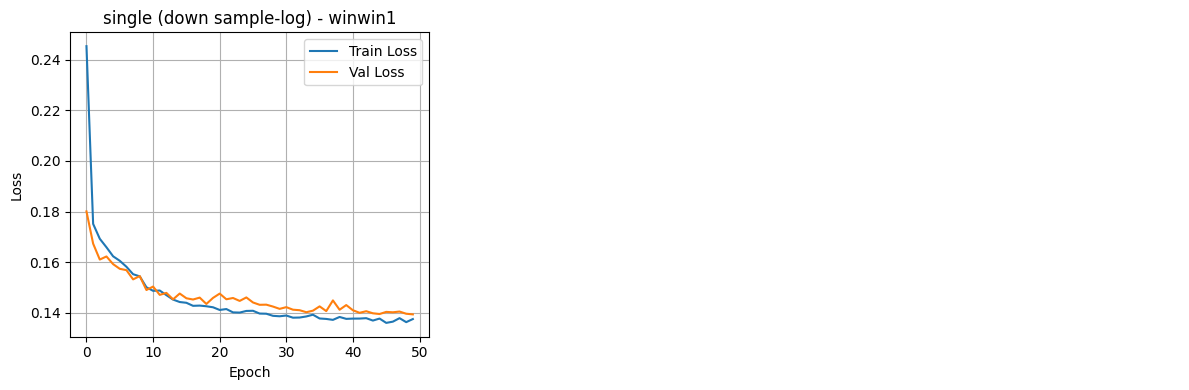

==> Window: 4
--> (7179, 4, 8) (7179,) (1577, 4, 8)
✅ Loaded model and history for window 4
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/single/plots/single_(down_sample-log)_loss_grid.png


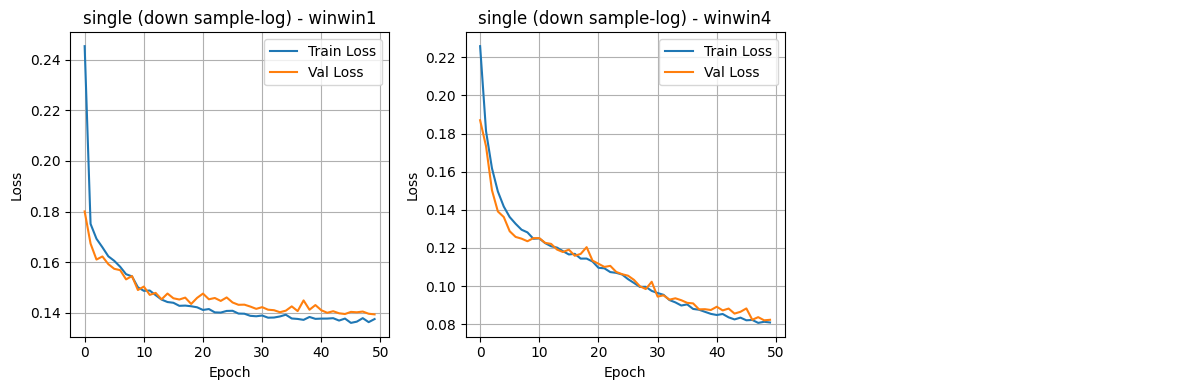

==> Window: 8
--> (7176, 8, 8) (7176,) (1576, 8, 8)
✅ Loaded model and history for window 8
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/single/plots/single_(down_sample-log)_loss_grid.png


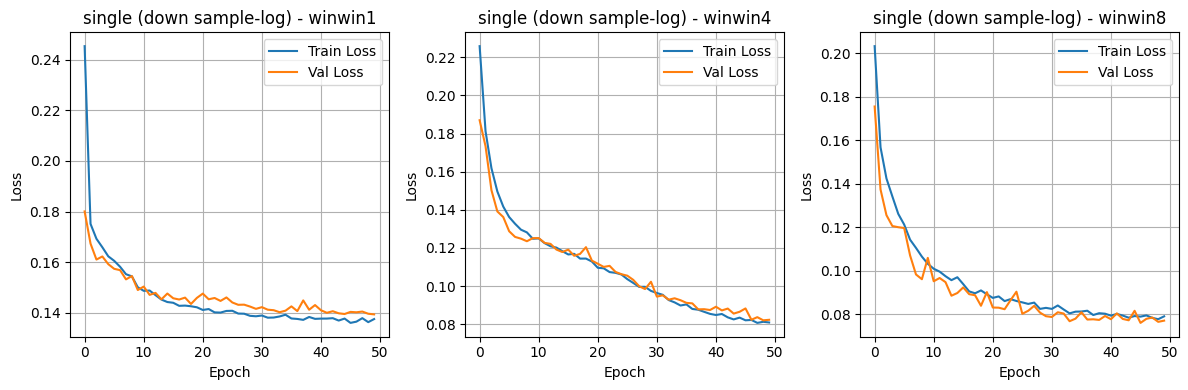

==> Window: 12
--> (7173, 12, 8) (7173,) (1575, 12, 8)
✅ Loaded model and history for window 12
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/single/plots/single_(down_sample-log)_loss_grid.png


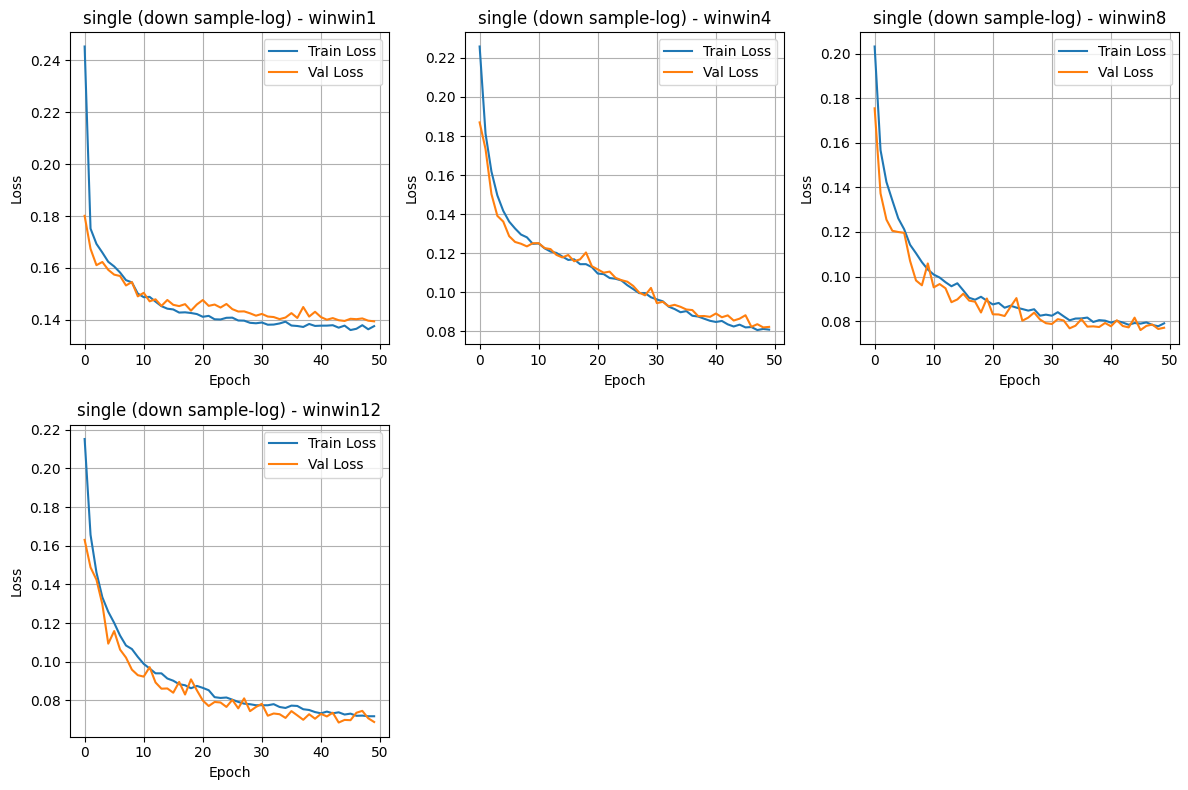

==> Window: 16
--> (7170, 16, 8) (7170,) (1574, 16, 8)
✅ Loaded model and history for window 16
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/single/plots/single_(down_sample-log)_loss_grid.png


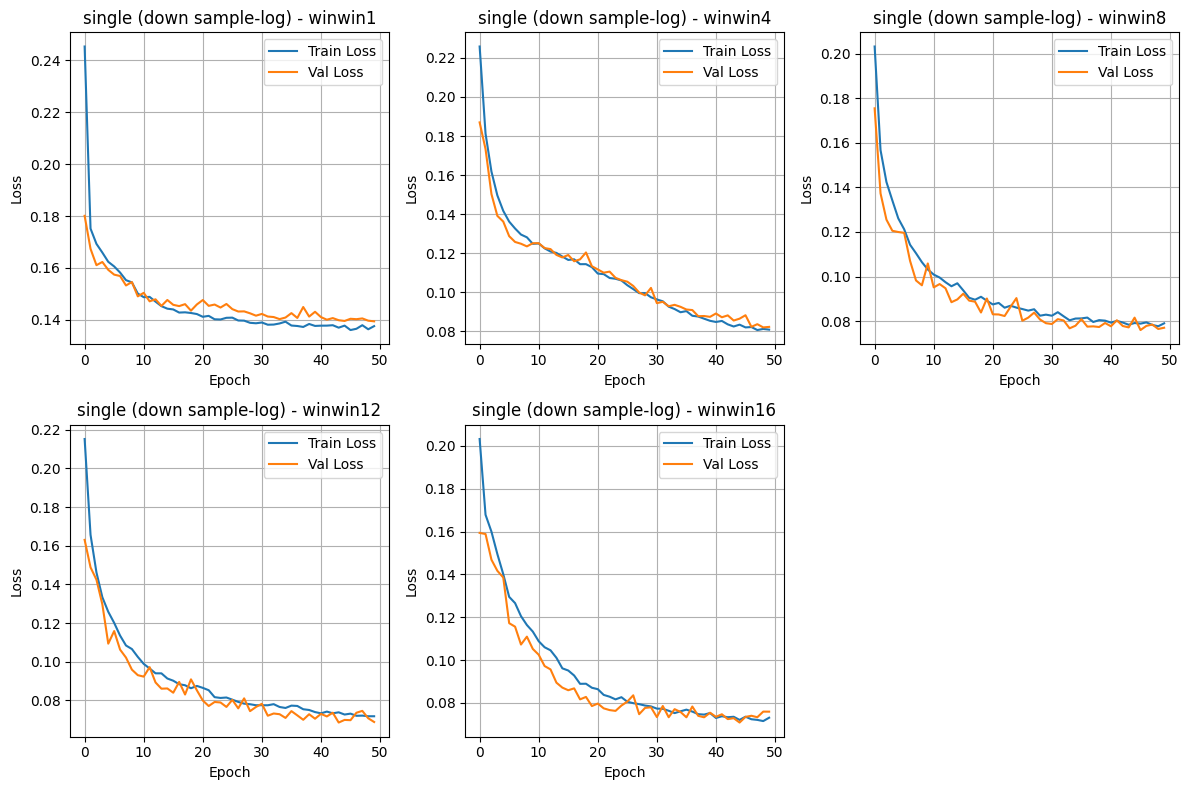

==> Window: 24
--> (7163, 24, 8) (7163,) (1573, 24, 8)
✅ Loaded model and history for window 24
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/single/plots/single_(down_sample-log)_loss_grid.png


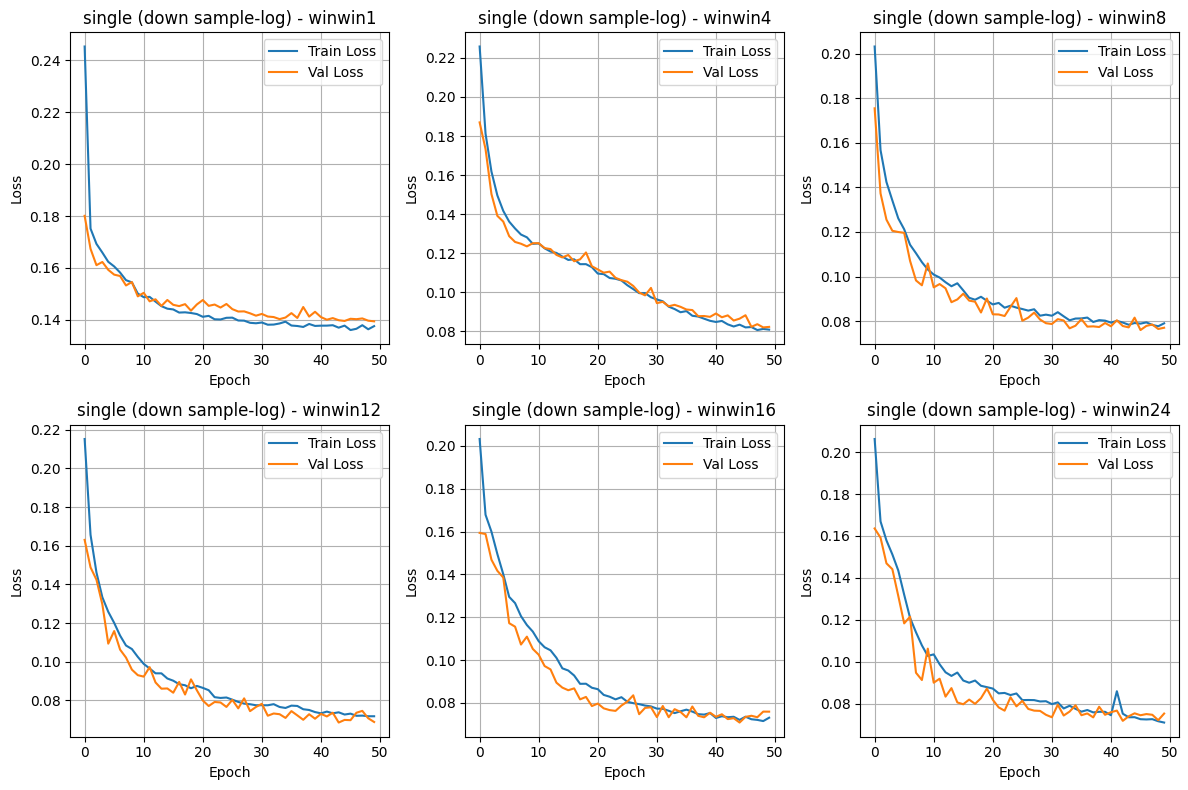

==> Window: 36
--> (7153, 36, 8) (7153,) (1571, 36, 8)
✅ Loaded model and history for window 36
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/single/plots/single_(down_sample-log)_loss_grid.png


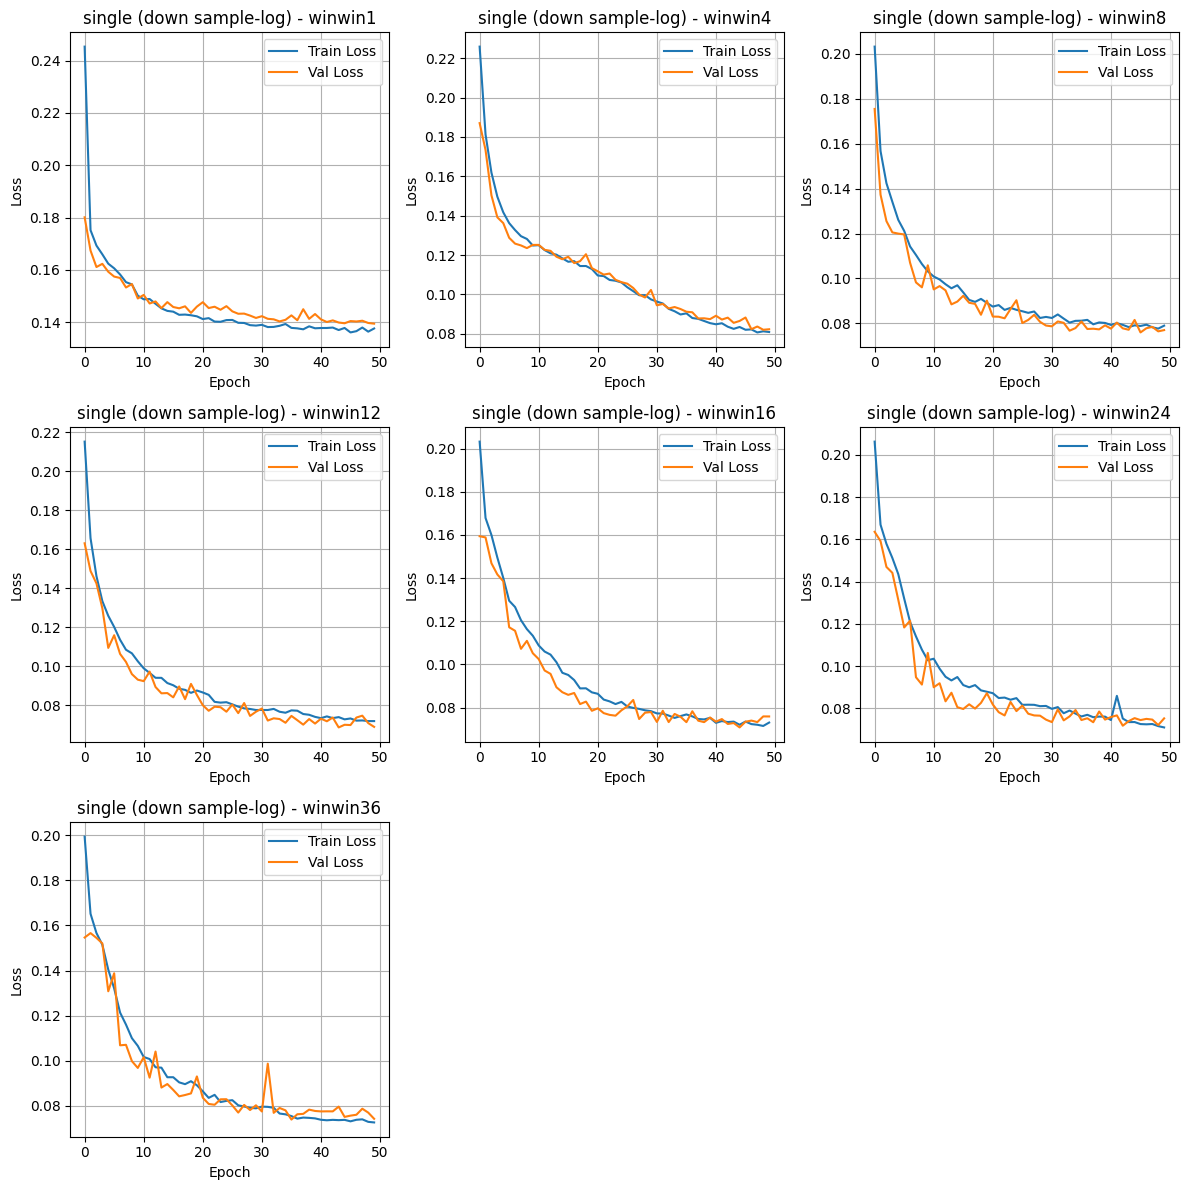

==> Window: 48
--> (7143, 48, 8) (7143,) (1569, 48, 8)
✅ Loaded model and history for window 48
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/single/plots/single_(down_sample-log)_loss_grid.png


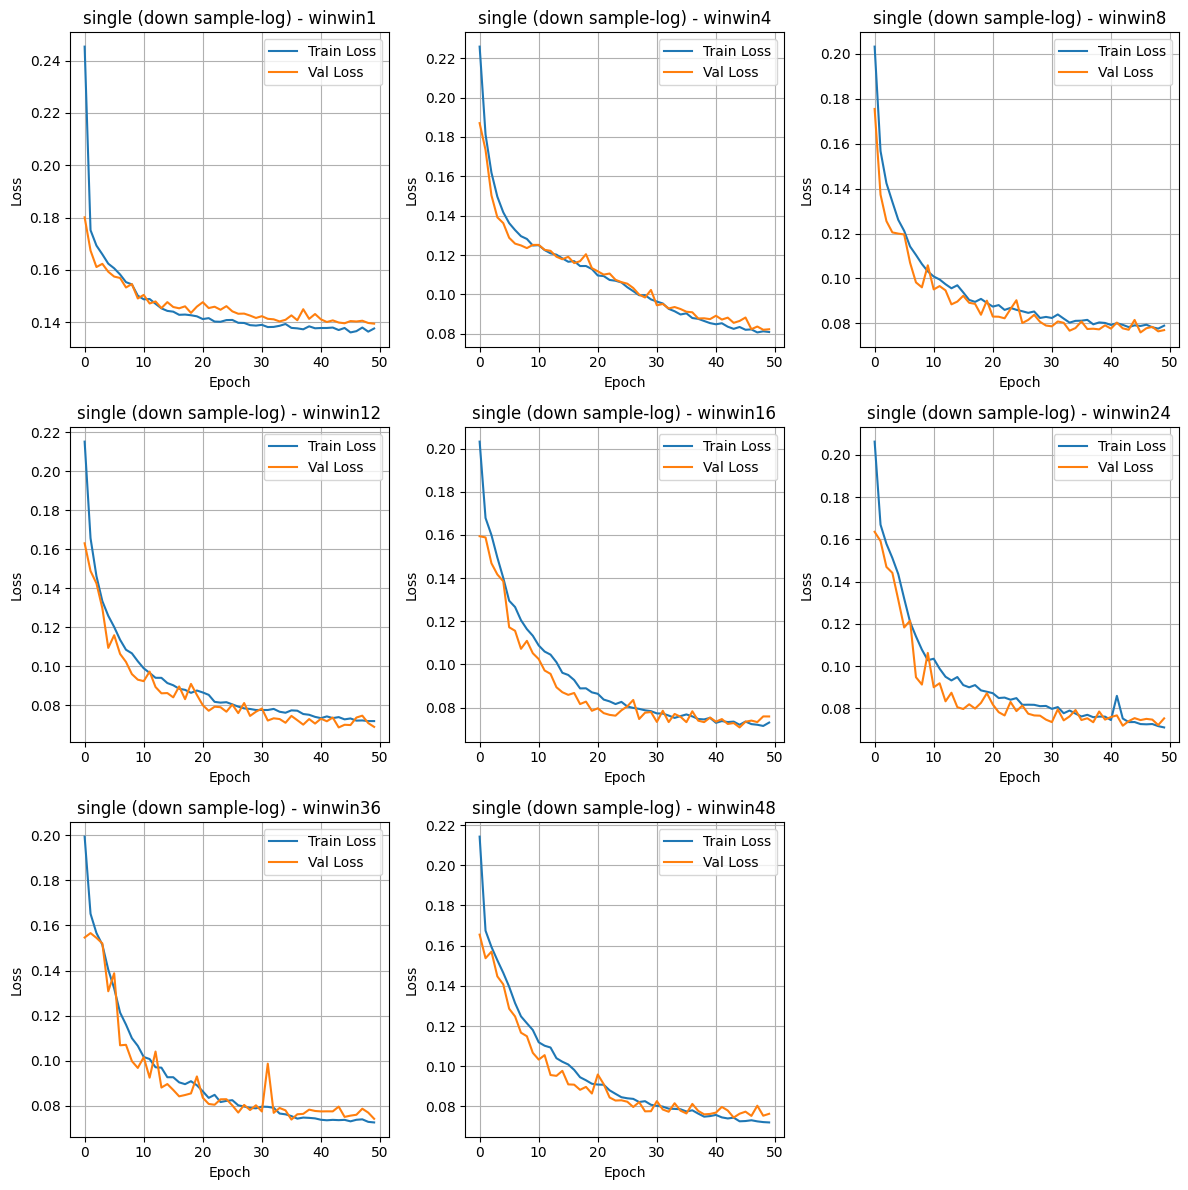

==> Window: 74
--> (7122, 74, 8) (7122,) (1564, 74, 8)
✅ Loaded model and history for window 74
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/single/plots/single_(down_sample-log)_loss_grid.png


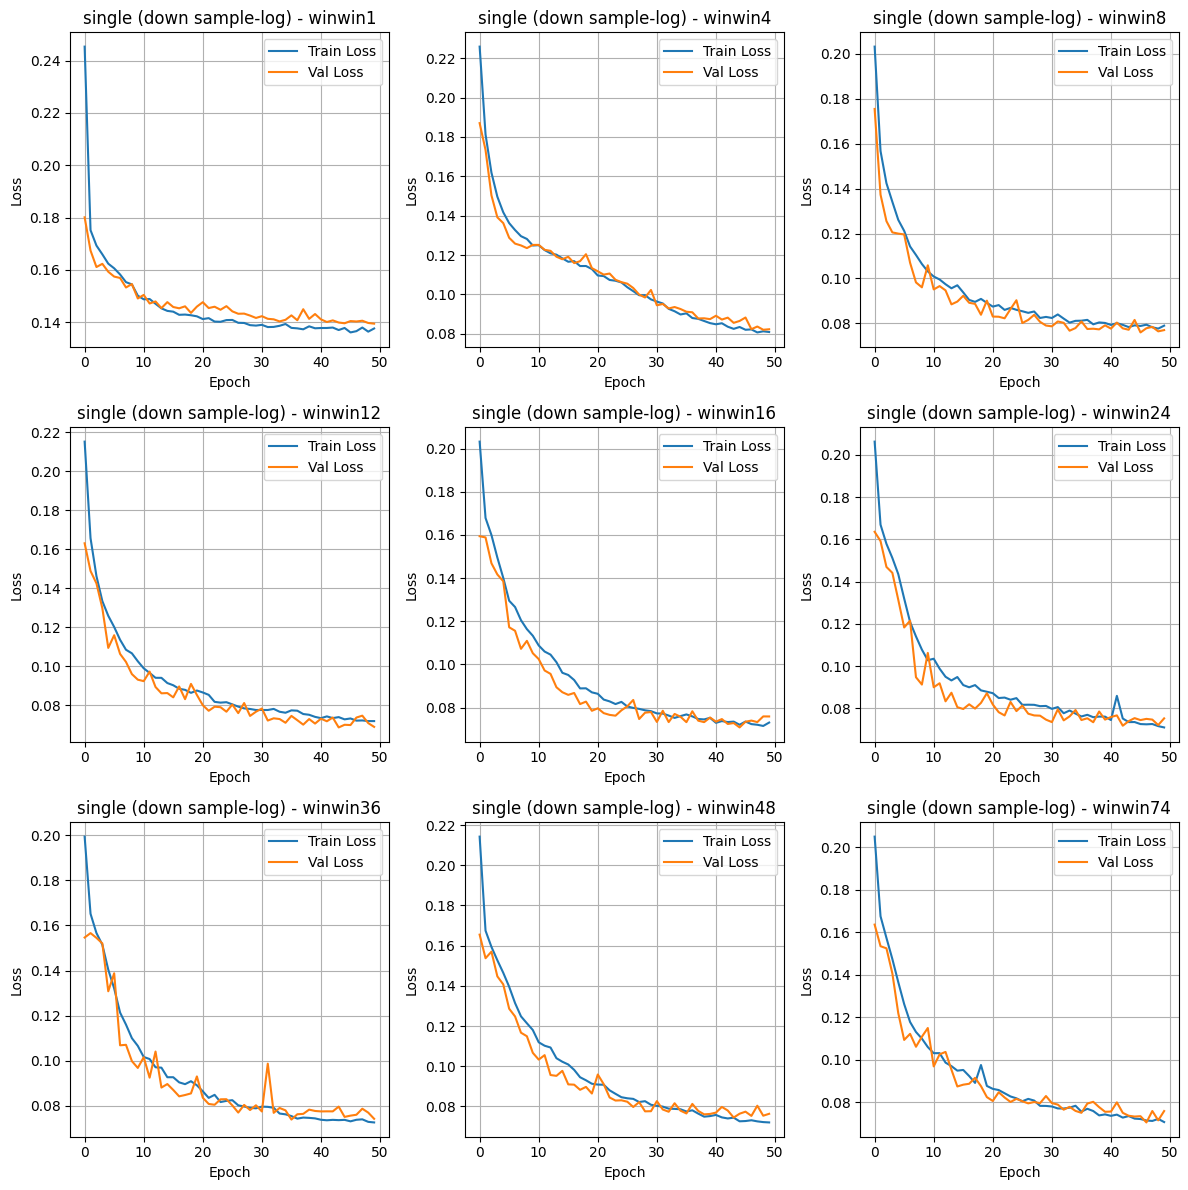

==> Window: 168
--> (7045, 168, 8) (7045,) (1547, 168, 8)
✅ Loaded model and history for window 168
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/single/plots/single_(down_sample-log)_loss_grid.png


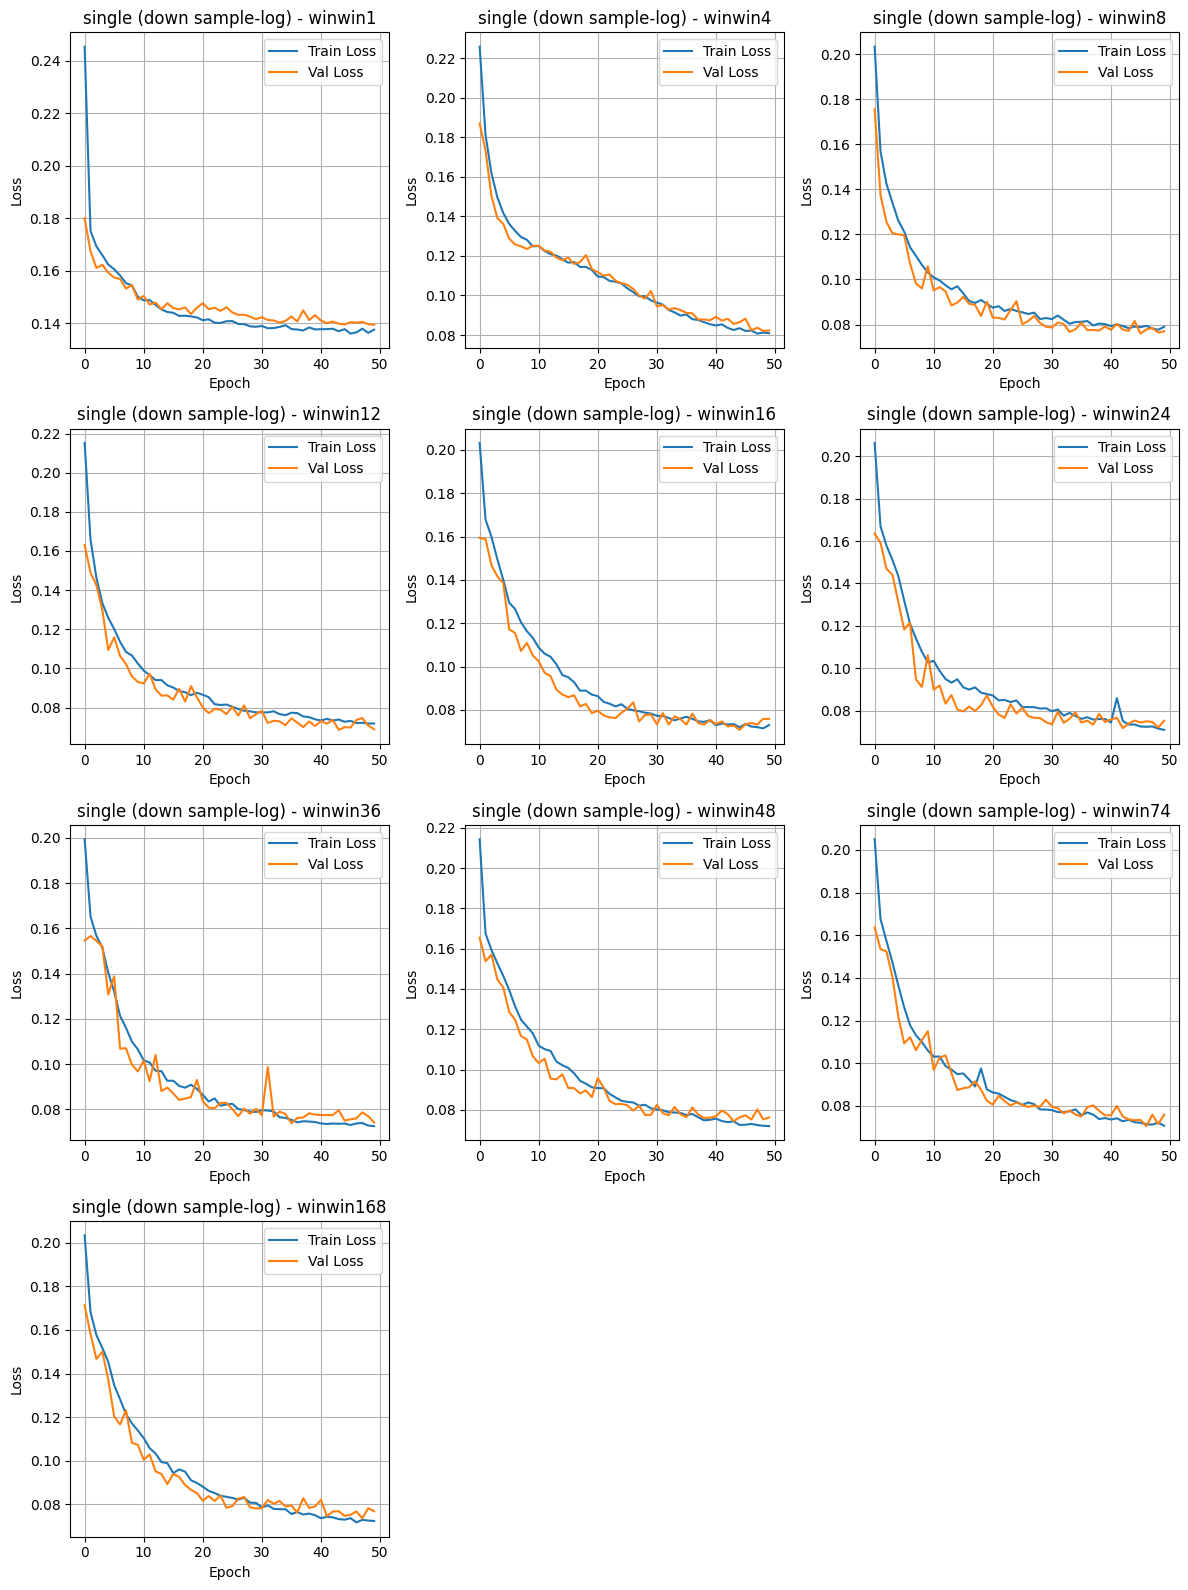

==> Window: 336
--> (6907, 336, 8) (6907,) (1517, 336, 8)
✅ Loaded model and history for window 336
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/single/plots/single_(down_sample-log)_loss_grid.png


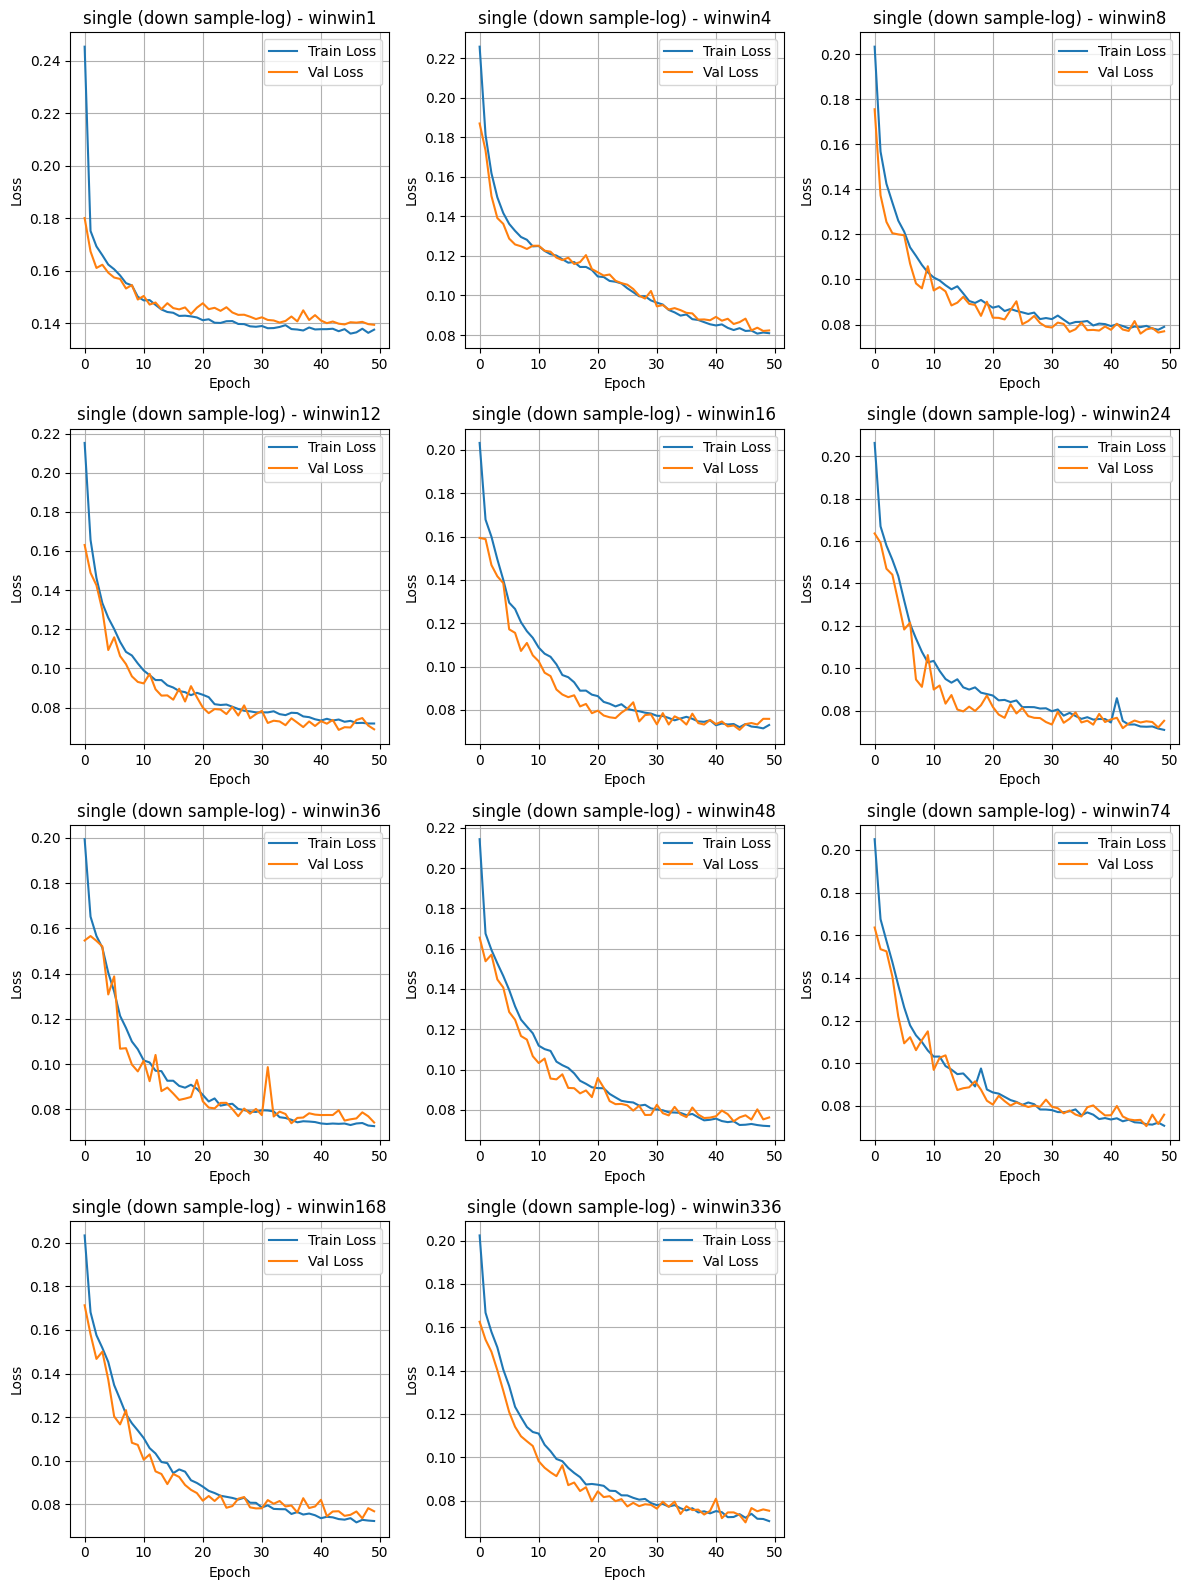

==> Window: 672
--> (6632, 672, 8) (6632,) (1456, 672, 8)
✅ Loaded model and history for window 672
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/single/plots/single_(down_sample-log)_loss_grid.png


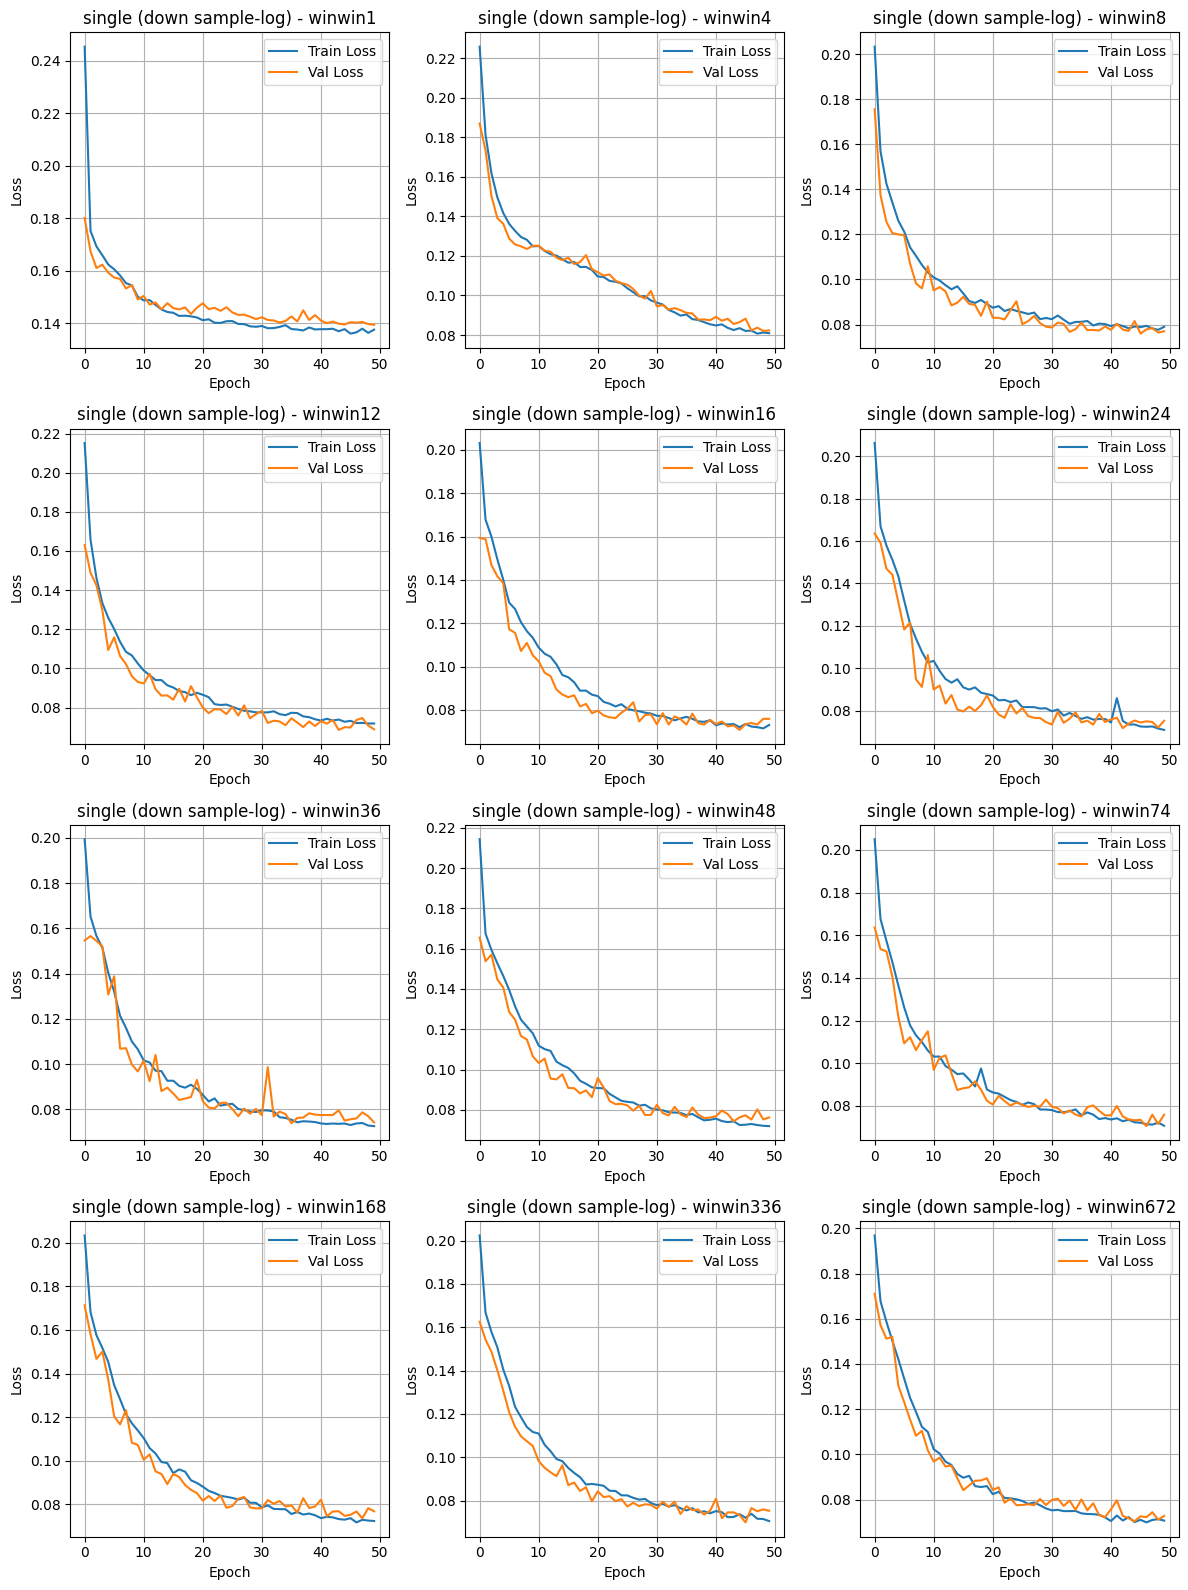

In [18]:
single_models = train("single", single_model_dir, single_history_dir, single_path)
# plot_histories_subplot(single_models, f"single {plot_name}")

double

In [19]:
double_model_dir = f"{double_path}/models"
double_history_dir = f"{double_path}/history"
os.makedirs(double_model_dir, exist_ok=True)
os.makedirs(double_history_dir, exist_ok=True)

==> Window: 1
--> (7182, 1, 8) (7182,) (1577, 1, 8)
✅ Loaded model and history for window 1
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/double/plots/double_(down_sample-log)_loss_grid.png


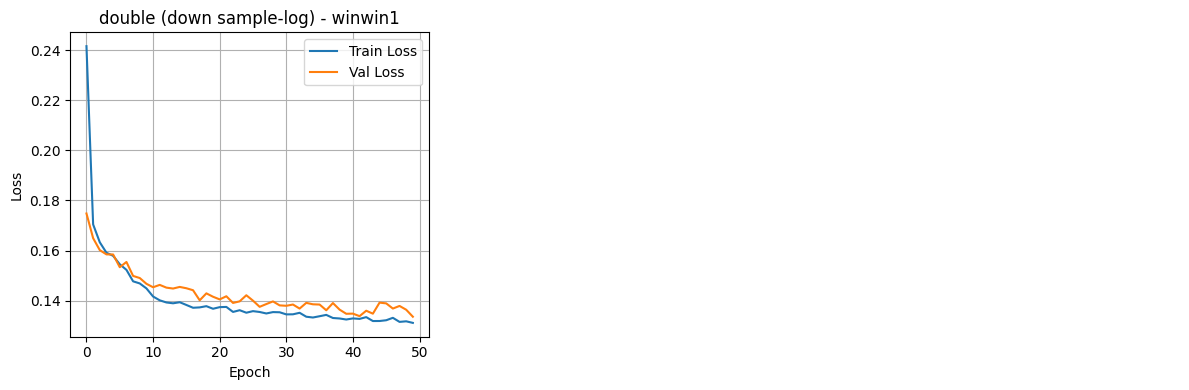

==> Window: 4
--> (7179, 4, 8) (7179,) (1577, 4, 8)
✅ Loaded model and history for window 4
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/double/plots/double_(down_sample-log)_loss_grid.png


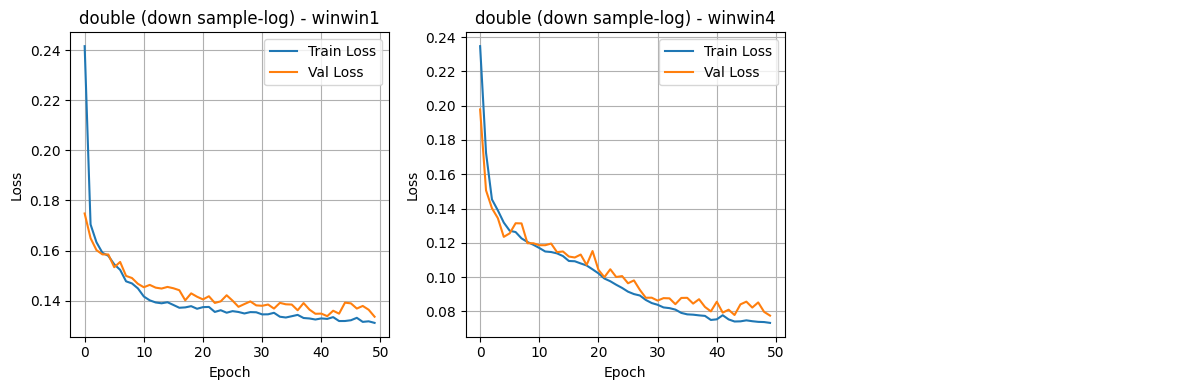

==> Window: 8
--> (7176, 8, 8) (7176,) (1576, 8, 8)
✅ Loaded model and history for window 8
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/double/plots/double_(down_sample-log)_loss_grid.png


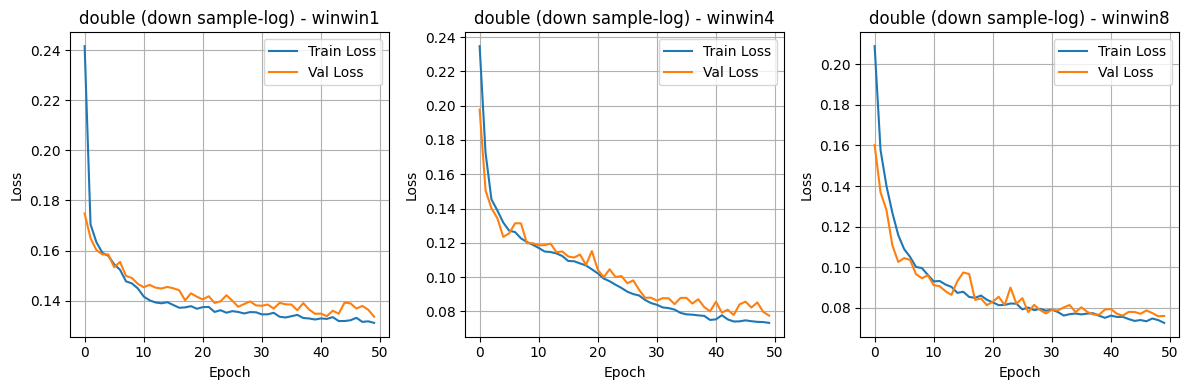

==> Window: 12
--> (7173, 12, 8) (7173,) (1575, 12, 8)
✅ Loaded model and history for window 12
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/double/plots/double_(down_sample-log)_loss_grid.png


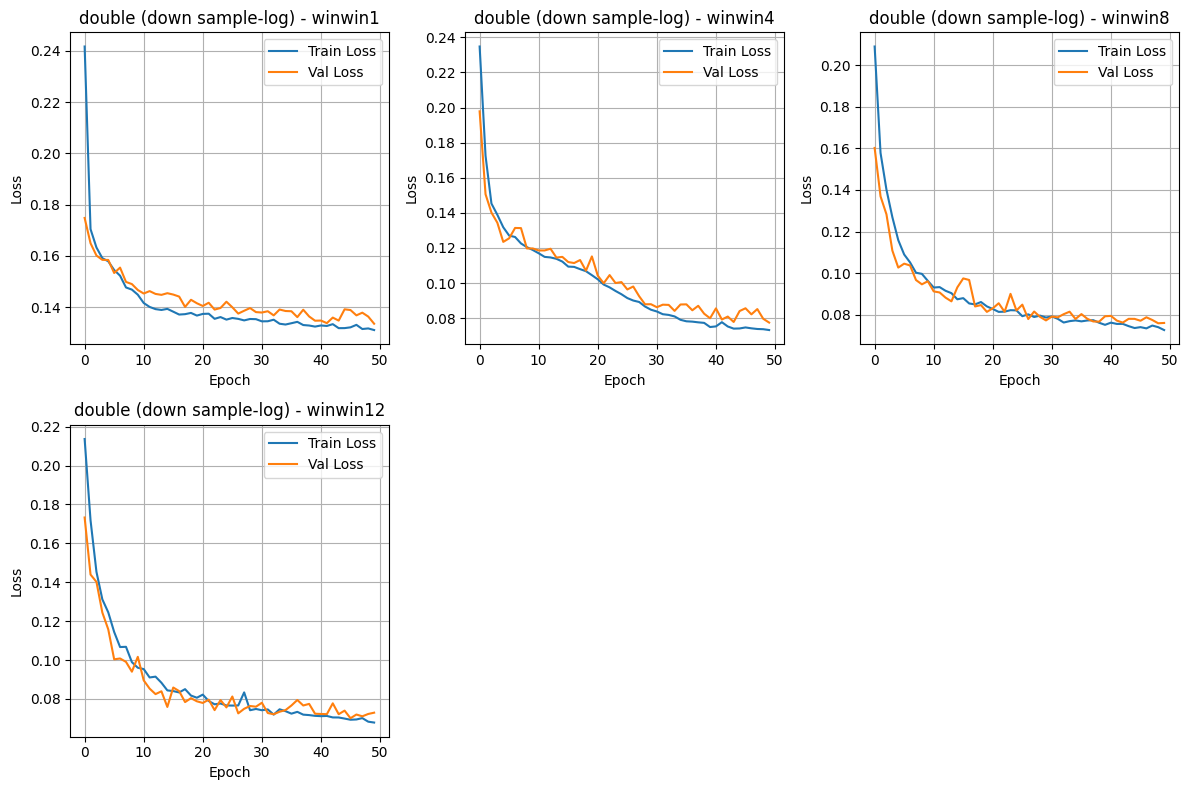

==> Window: 16
--> (7170, 16, 8) (7170,) (1574, 16, 8)
✅ Loaded model and history for window 16
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/double/plots/double_(down_sample-log)_loss_grid.png


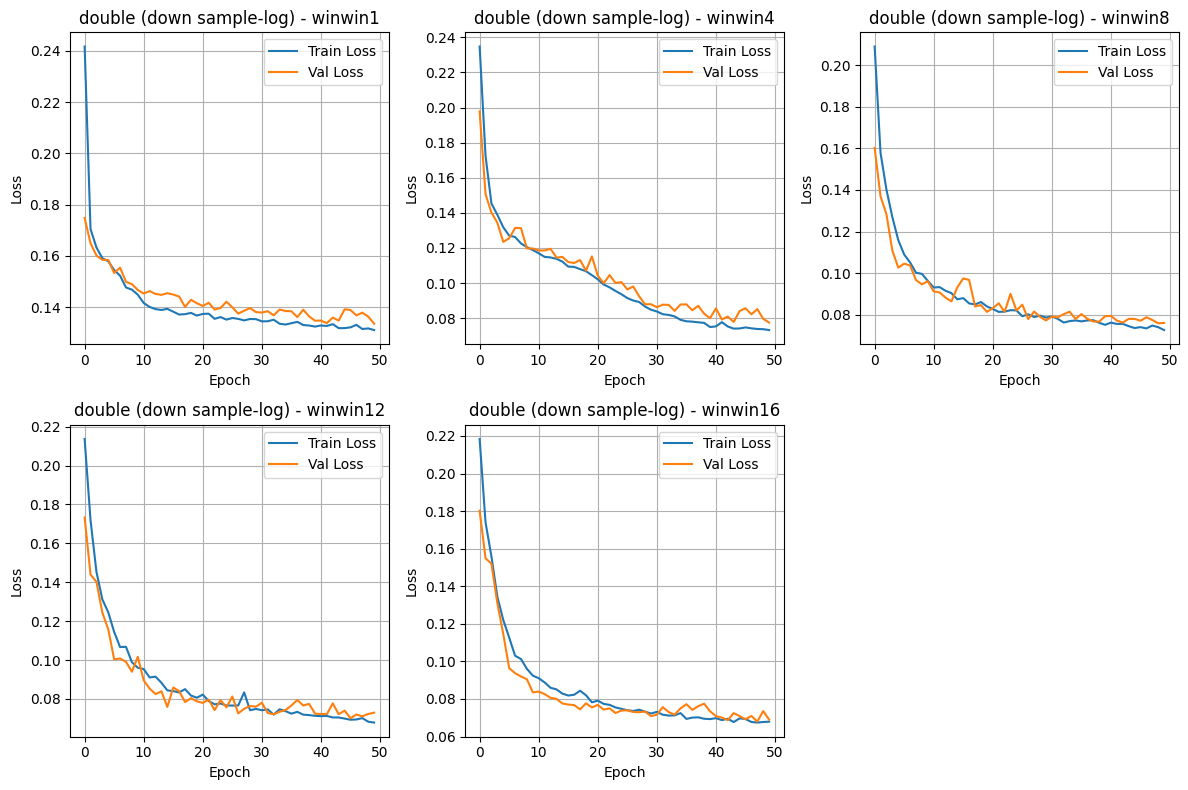

==> Window: 24
--> (7163, 24, 8) (7163,) (1573, 24, 8)
✅ Loaded model and history for window 24
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/double/plots/double_(down_sample-log)_loss_grid.png


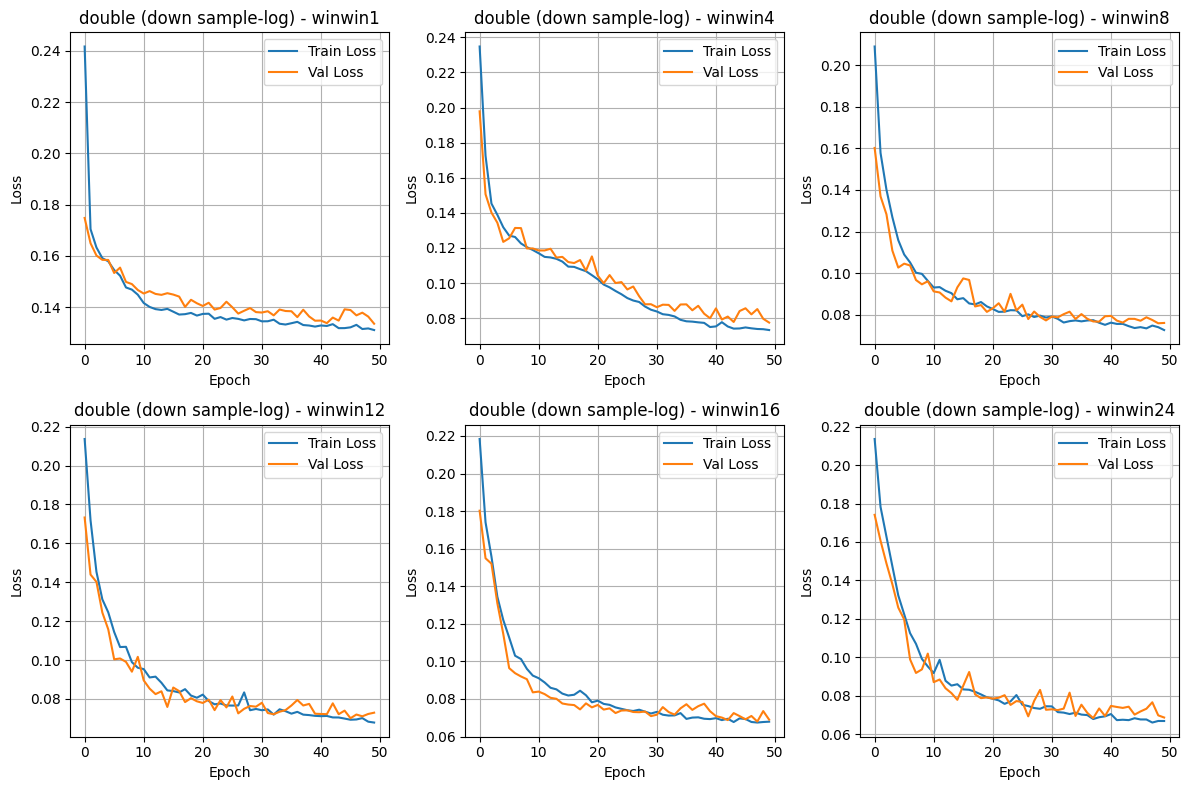

==> Window: 36
--> (7153, 36, 8) (7153,) (1571, 36, 8)
✅ Loaded model and history for window 36
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/double/plots/double_(down_sample-log)_loss_grid.png


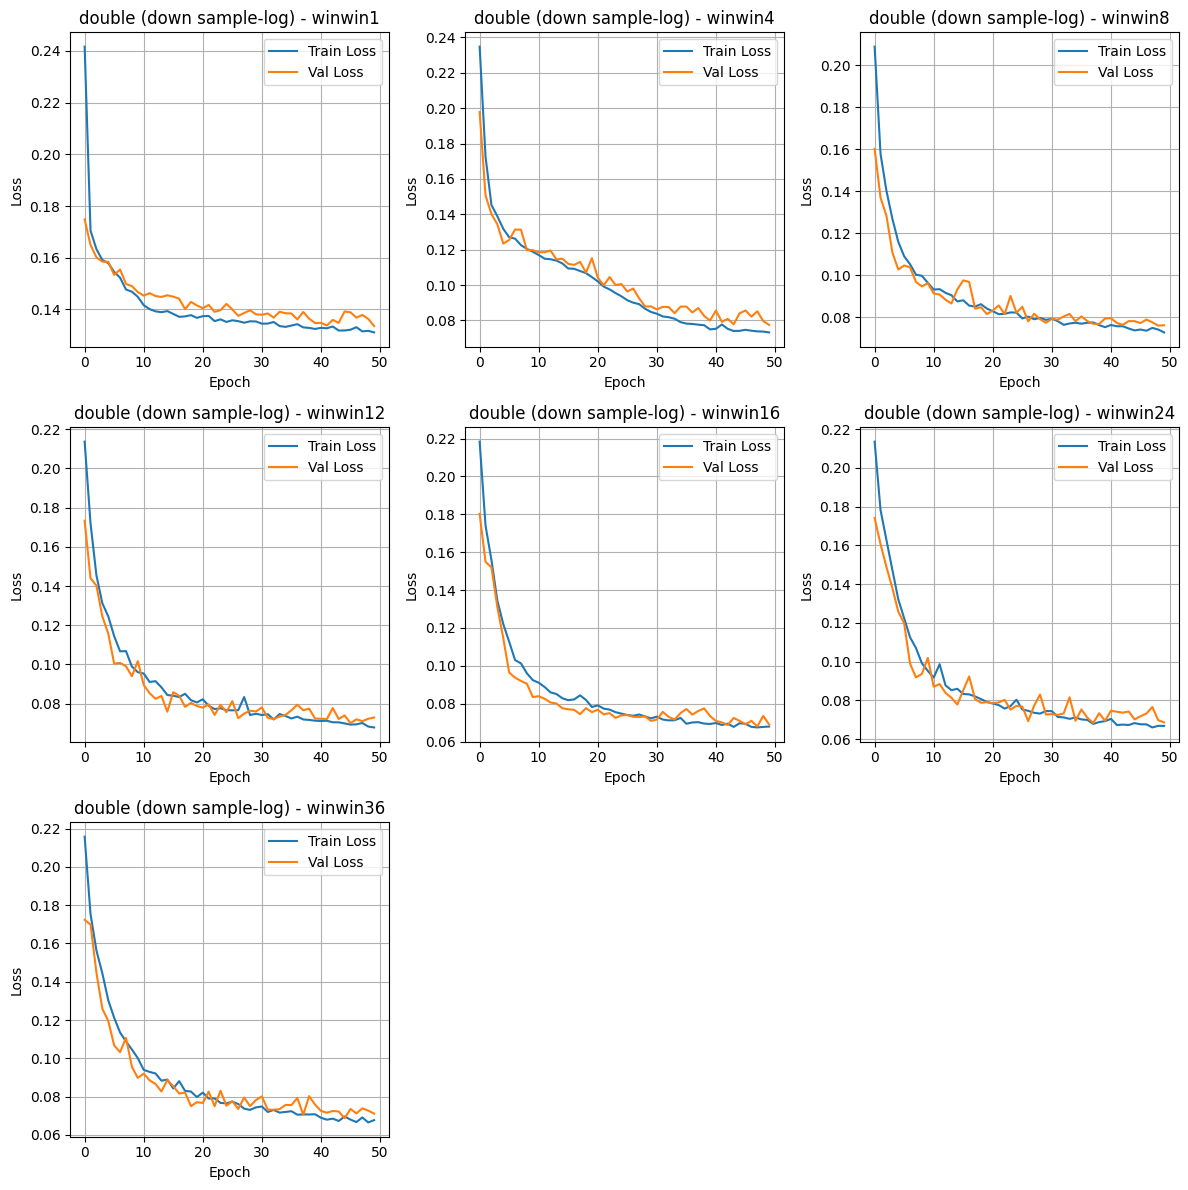

==> Window: 48
--> (7143, 48, 8) (7143,) (1569, 48, 8)
✅ Loaded model and history for window 48
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/double/plots/double_(down_sample-log)_loss_grid.png


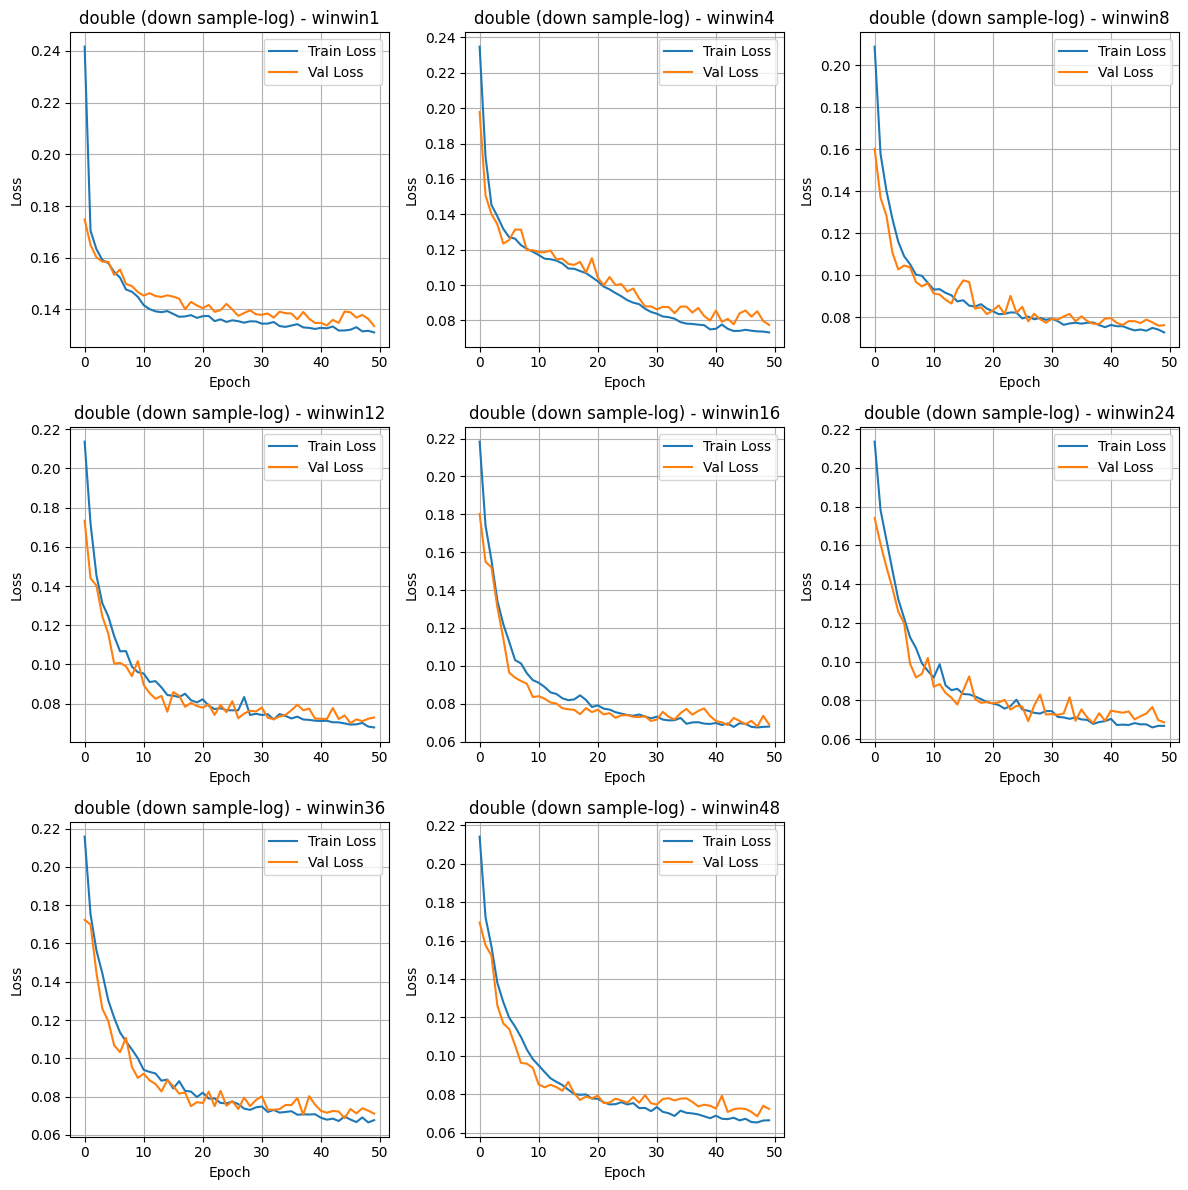

==> Window: 74
--> (7122, 74, 8) (7122,) (1564, 74, 8)
✅ Loaded model and history for window 74
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/double/plots/double_(down_sample-log)_loss_grid.png


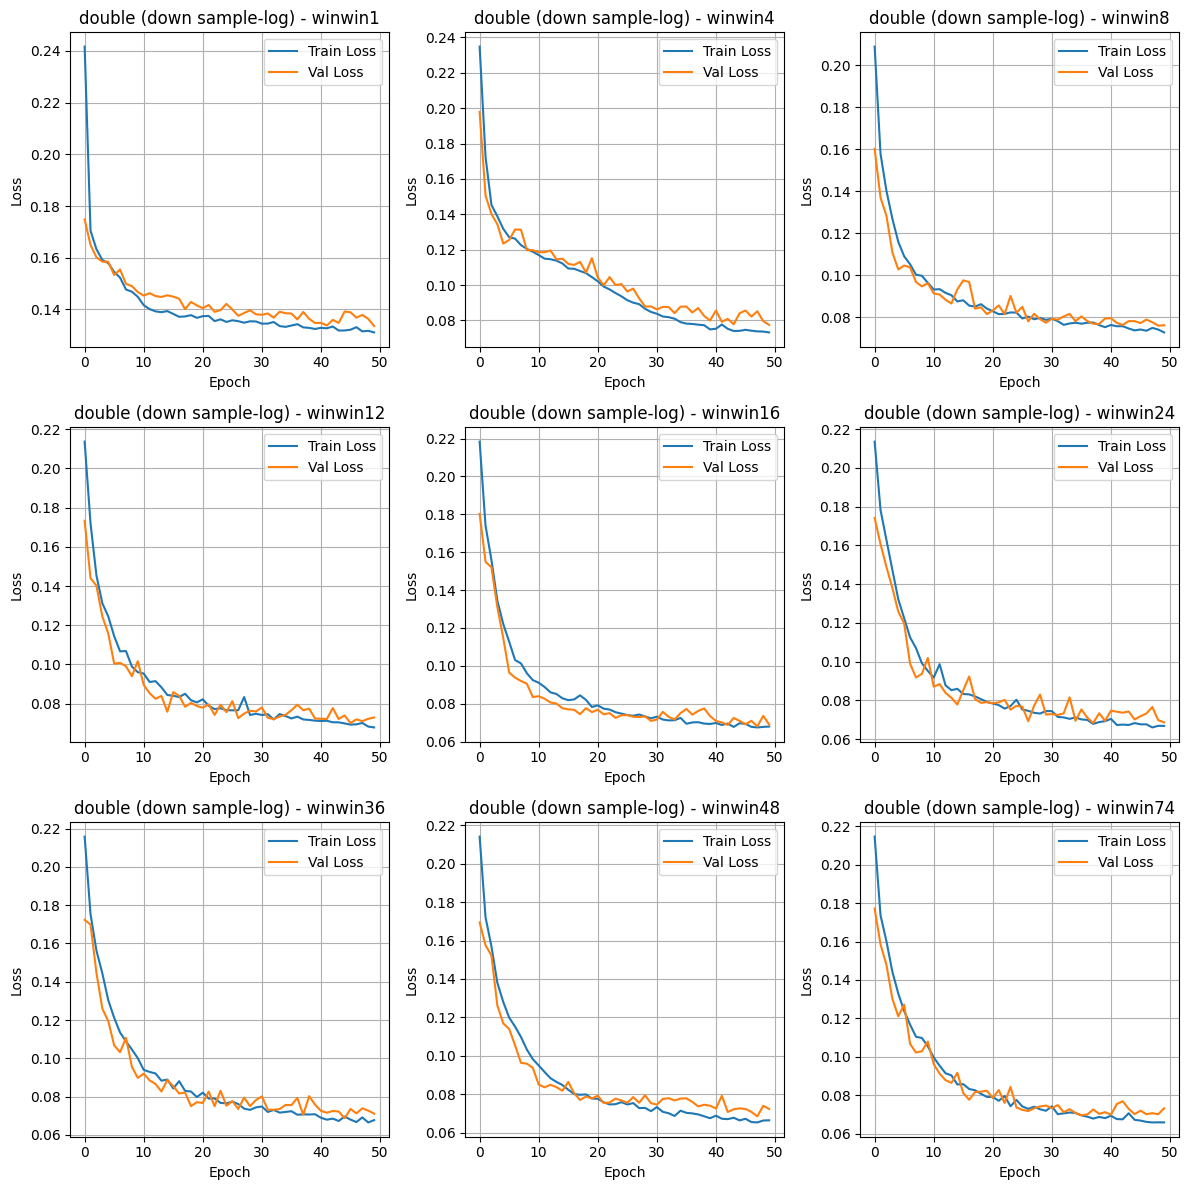

==> Window: 168
--> (7045, 168, 8) (7045,) (1547, 168, 8)
✅ Loaded model and history for window 168
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/double/plots/double_(down_sample-log)_loss_grid.png


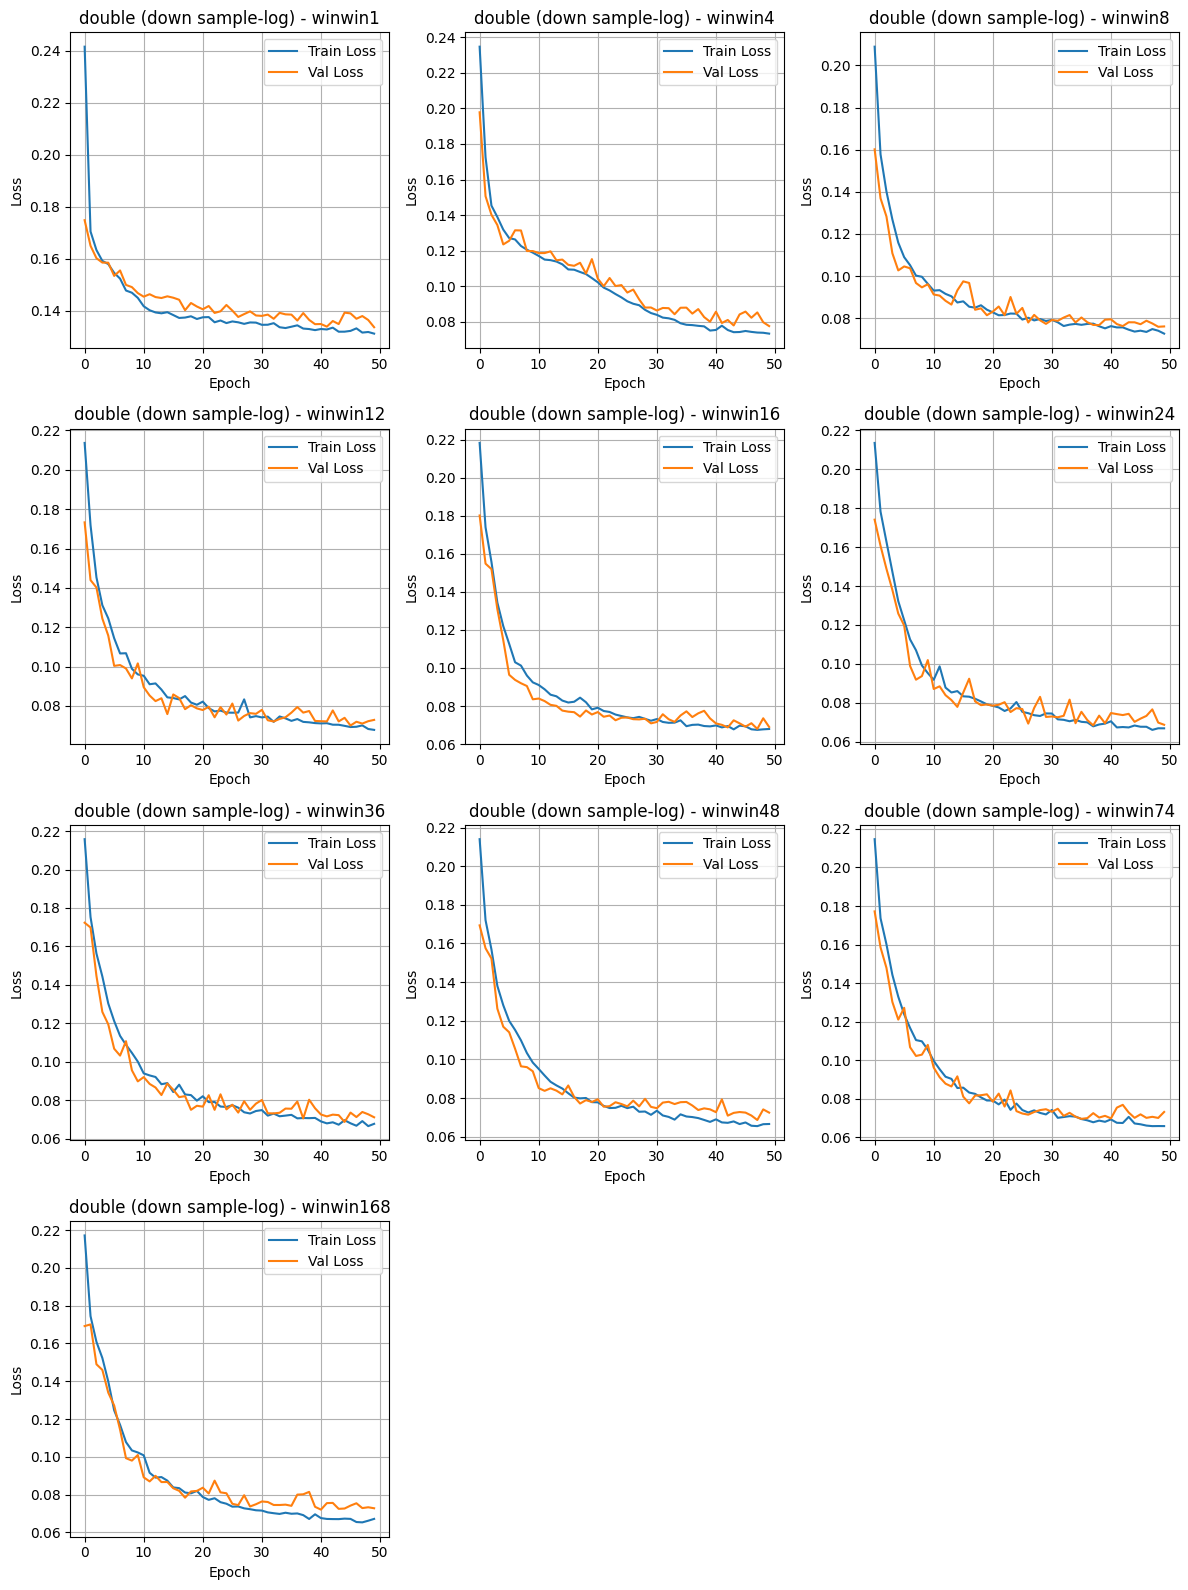

==> Window: 336
--> (6907, 336, 8) (6907,) (1517, 336, 8)
✅ Loaded model and history for window 336
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/double/plots/double_(down_sample-log)_loss_grid.png


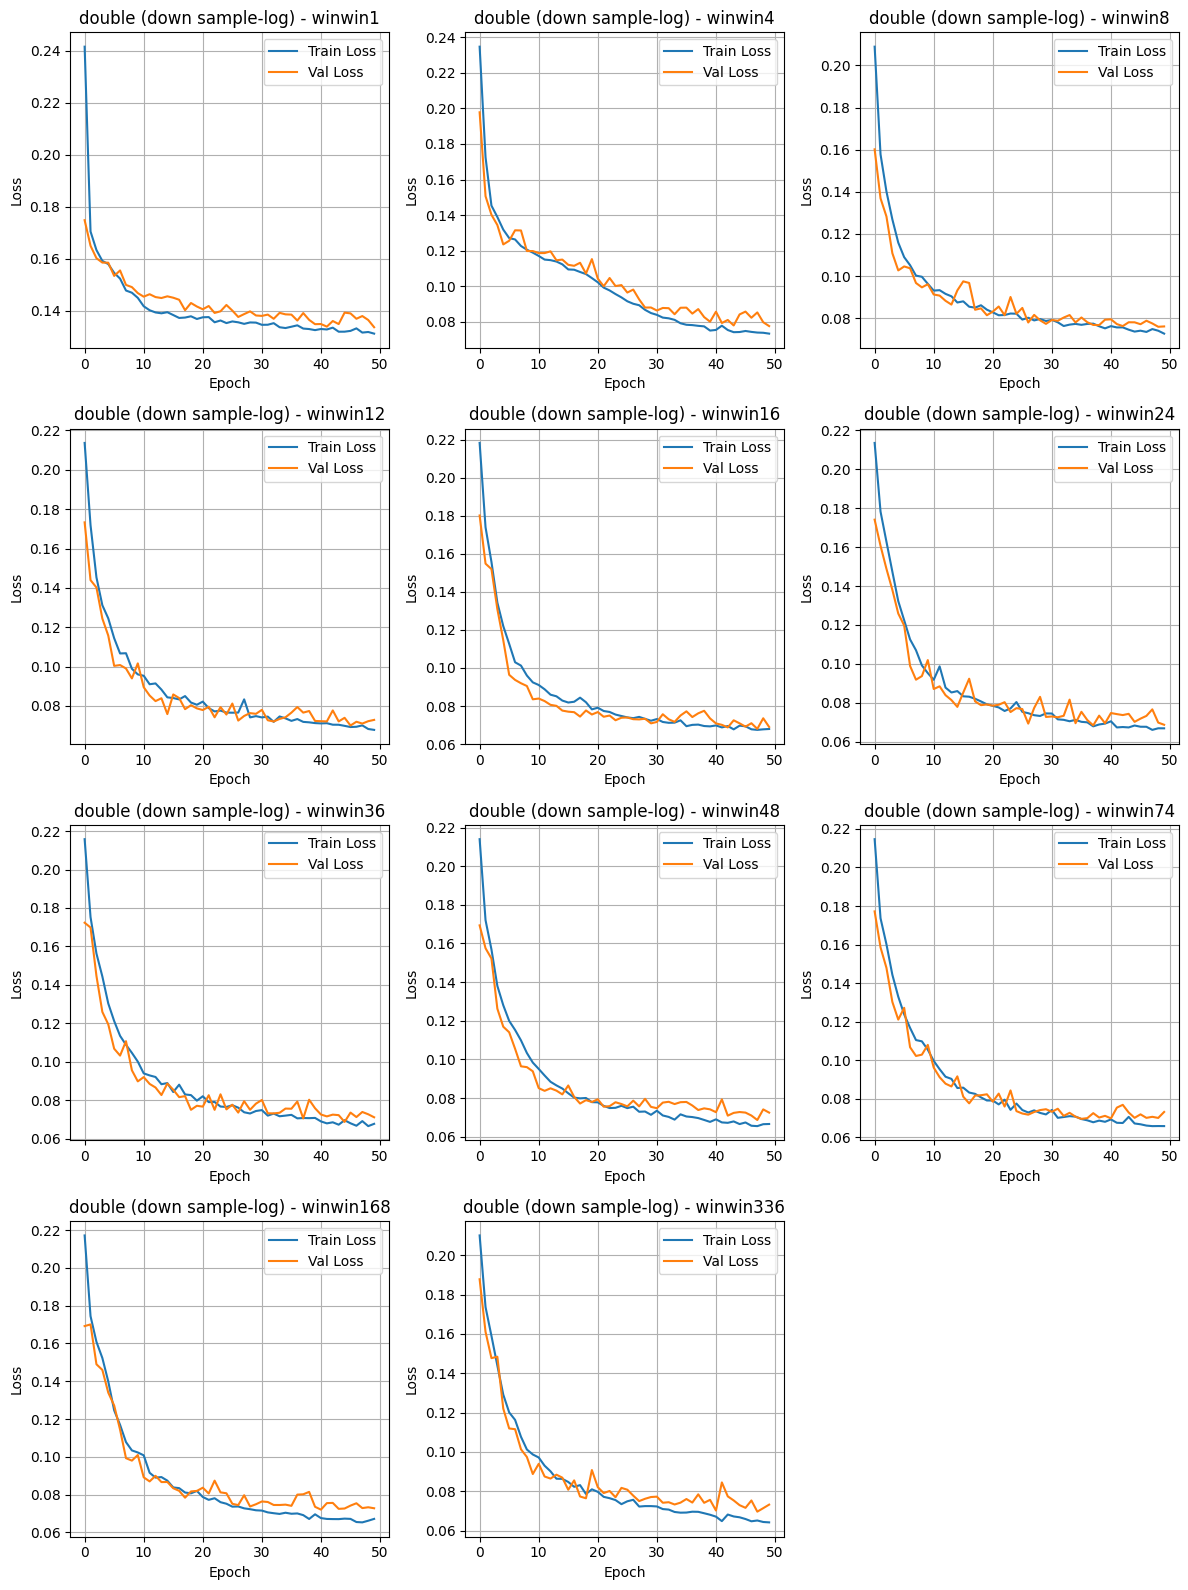

==> Window: 672
--> (6632, 672, 8) (6632,) (1456, 672, 8)
✅ Loaded model and history for window 672
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/double/plots/double_(down_sample-log)_loss_grid.png


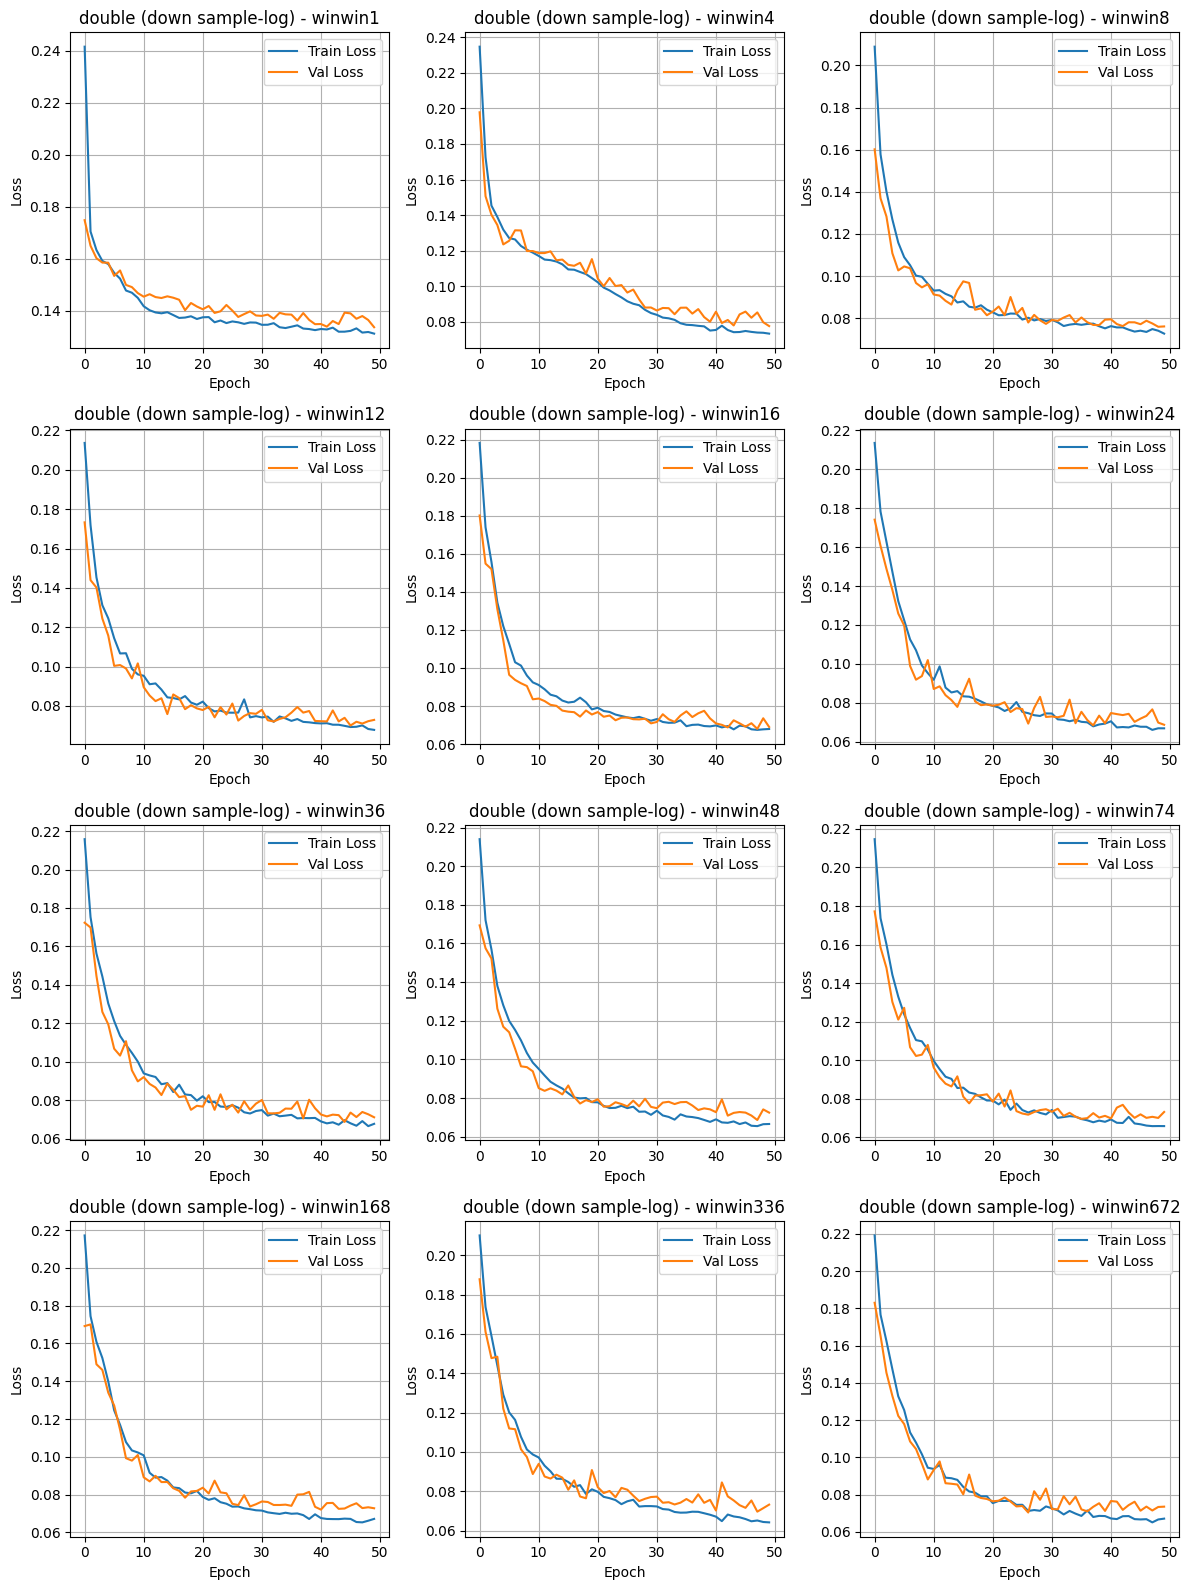

In [20]:
double_models =train("double",double_model_dir, double_history_dir, double_path)

bi dir

In [21]:
bidir_model_dir = f"{bidir_path}/models"
bidir_history_dir = f"{bidir_path}/history"
os.makedirs(bidir_model_dir, exist_ok=True)
os.makedirs(bidir_history_dir, exist_ok=True)

==> Window: 1
--> (7182, 1, 8) (7182,) (1577, 1, 8)
✅ Loaded model and history for window 1
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/bidir/plots/bidir_(down_sample-log)_loss_grid.png


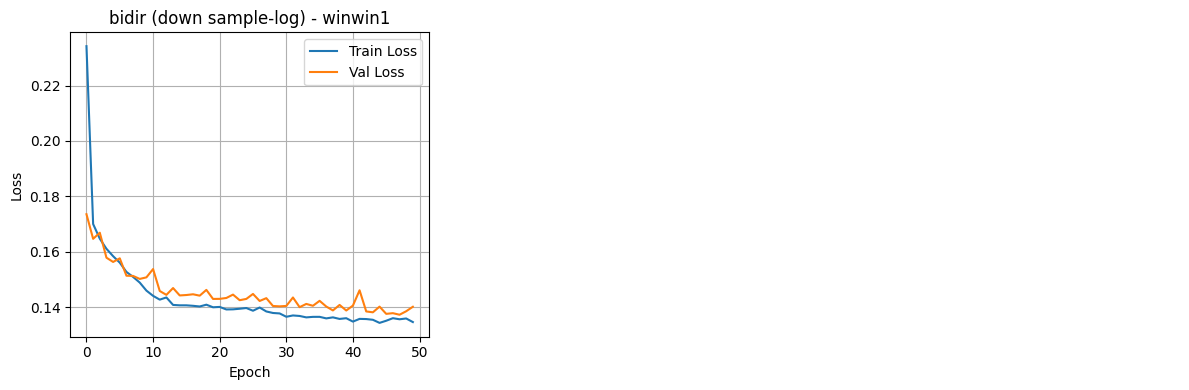

==> Window: 4
--> (7179, 4, 8) (7179,) (1577, 4, 8)
✅ Loaded model and history for window 4
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/bidir/plots/bidir_(down_sample-log)_loss_grid.png


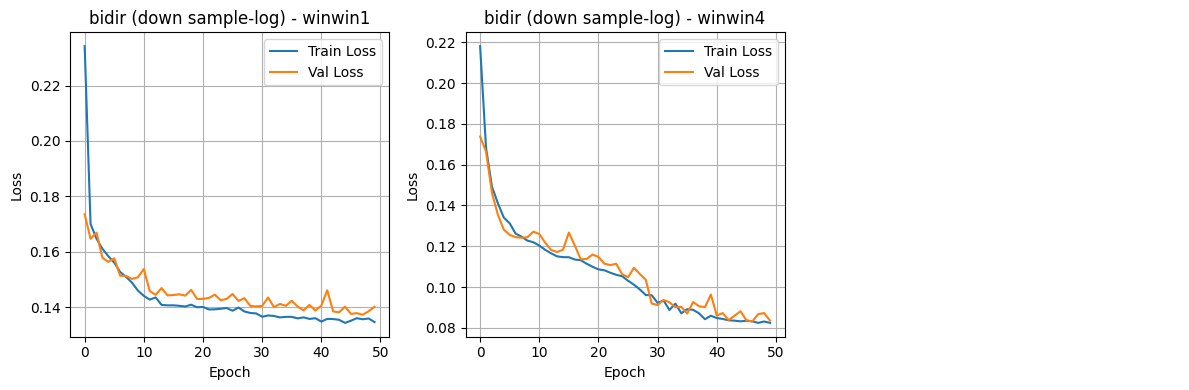

==> Window: 8
--> (7176, 8, 8) (7176,) (1576, 8, 8)
✅ Loaded model and history for window 8
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/bidir/plots/bidir_(down_sample-log)_loss_grid.png


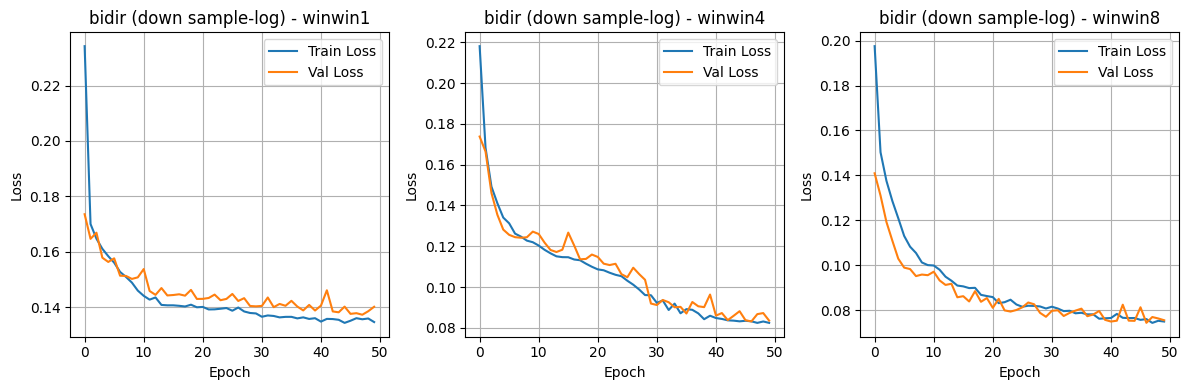

==> Window: 12
--> (7173, 12, 8) (7173,) (1575, 12, 8)
✅ Loaded model and history for window 12
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/bidir/plots/bidir_(down_sample-log)_loss_grid.png


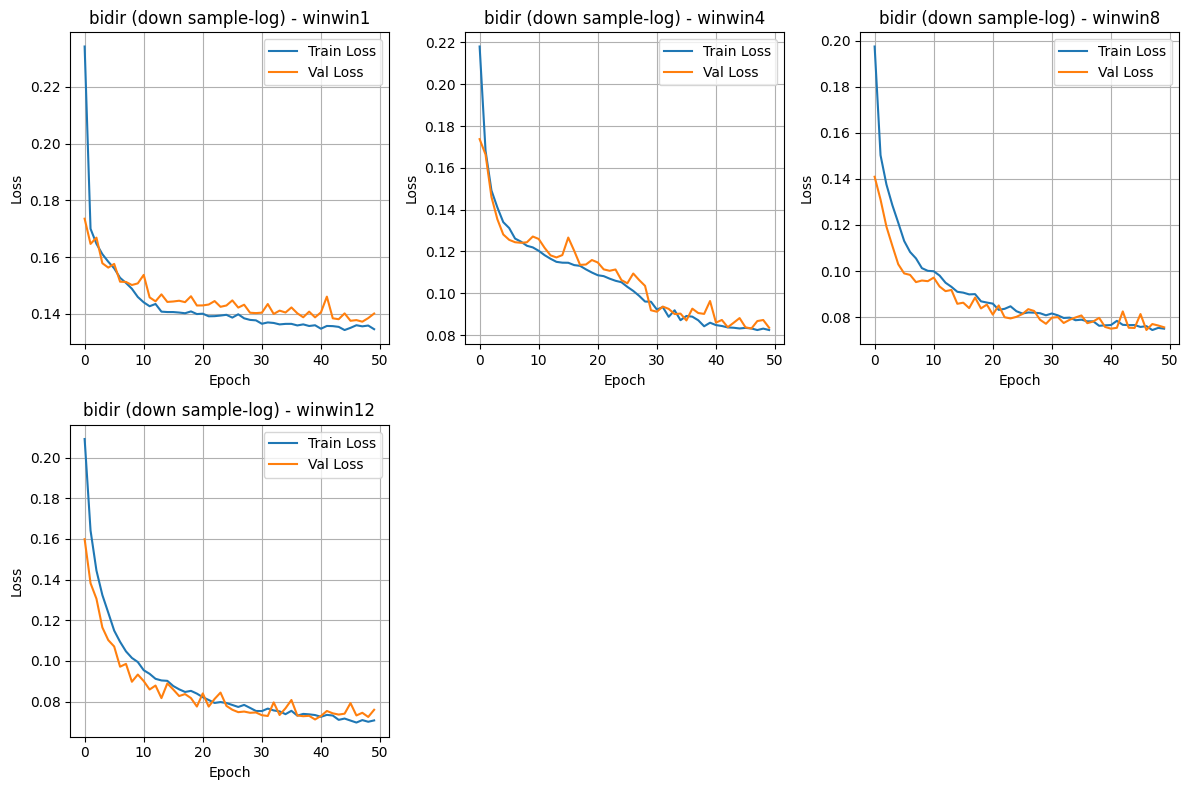

==> Window: 16
--> (7170, 16, 8) (7170,) (1574, 16, 8)
✅ Loaded model and history for window 16
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/bidir/plots/bidir_(down_sample-log)_loss_grid.png


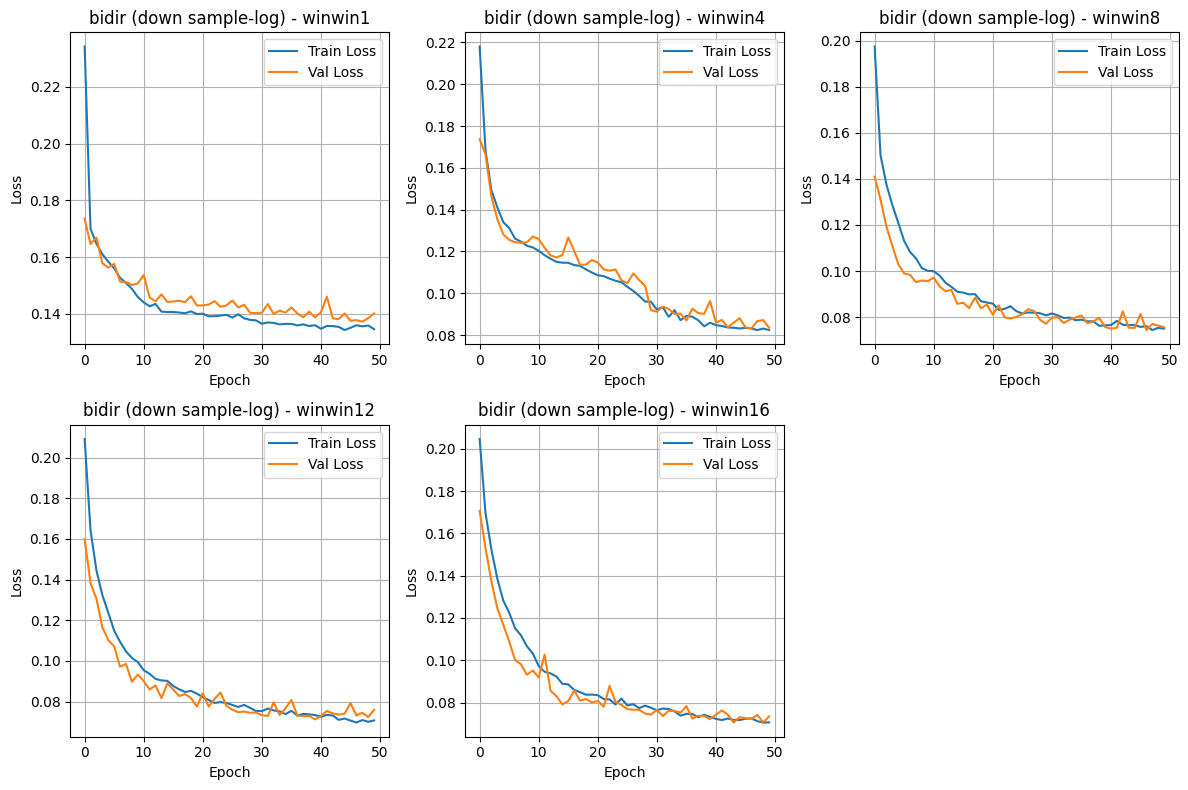

==> Window: 24
--> (7163, 24, 8) (7163,) (1573, 24, 8)
✅ Loaded model and history for window 24
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/bidir/plots/bidir_(down_sample-log)_loss_grid.png


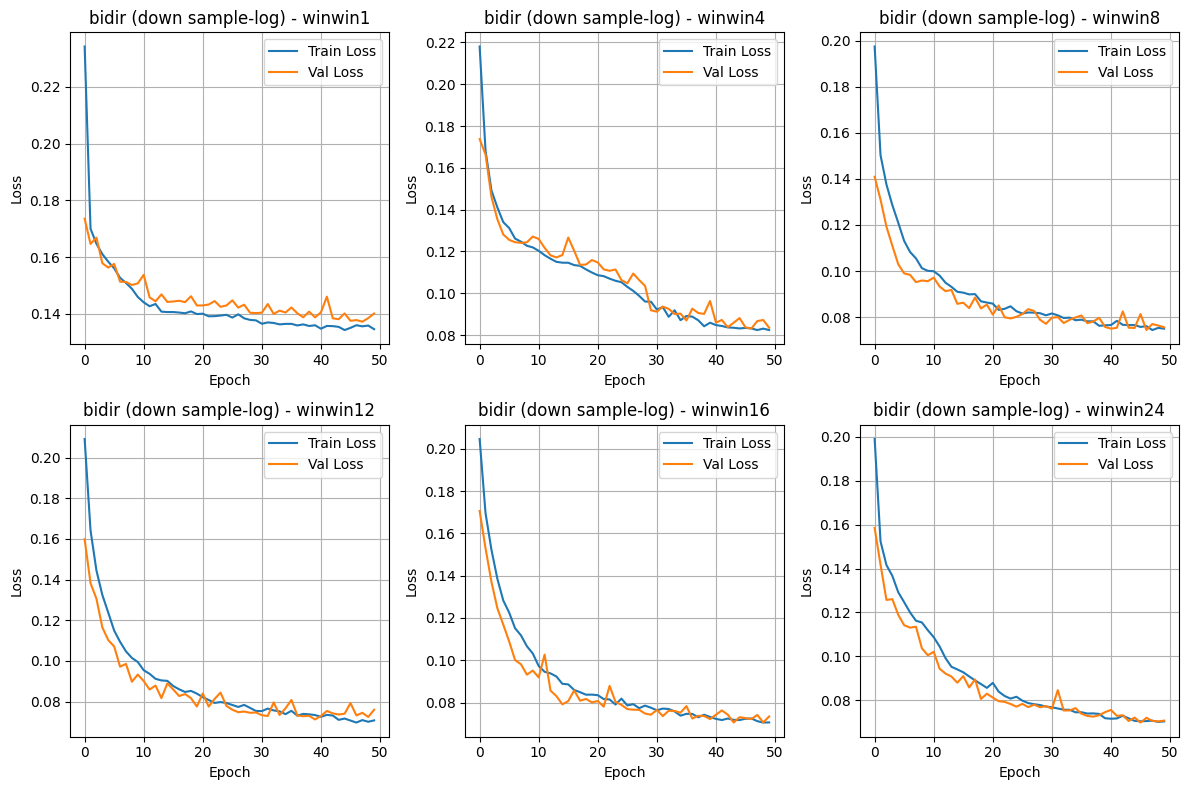

==> Window: 36
--> (7153, 36, 8) (7153,) (1571, 36, 8)
✅ Loaded model and history for window 36
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/bidir/plots/bidir_(down_sample-log)_loss_grid.png


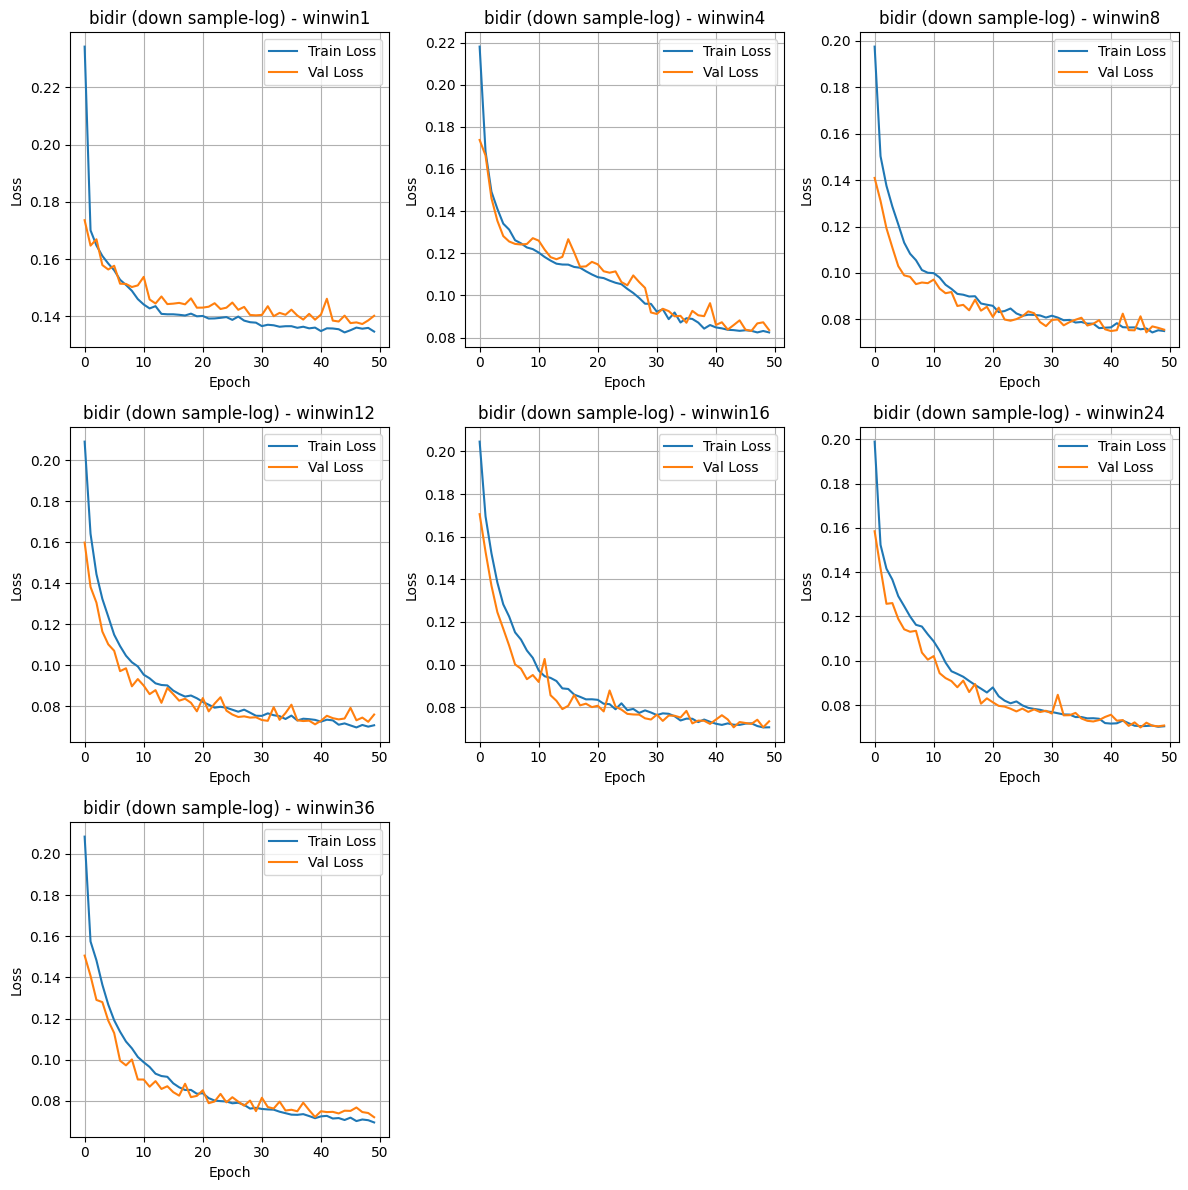

==> Window: 48
--> (7143, 48, 8) (7143,) (1569, 48, 8)
✅ Loaded model and history for window 48
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/bidir/plots/bidir_(down_sample-log)_loss_grid.png


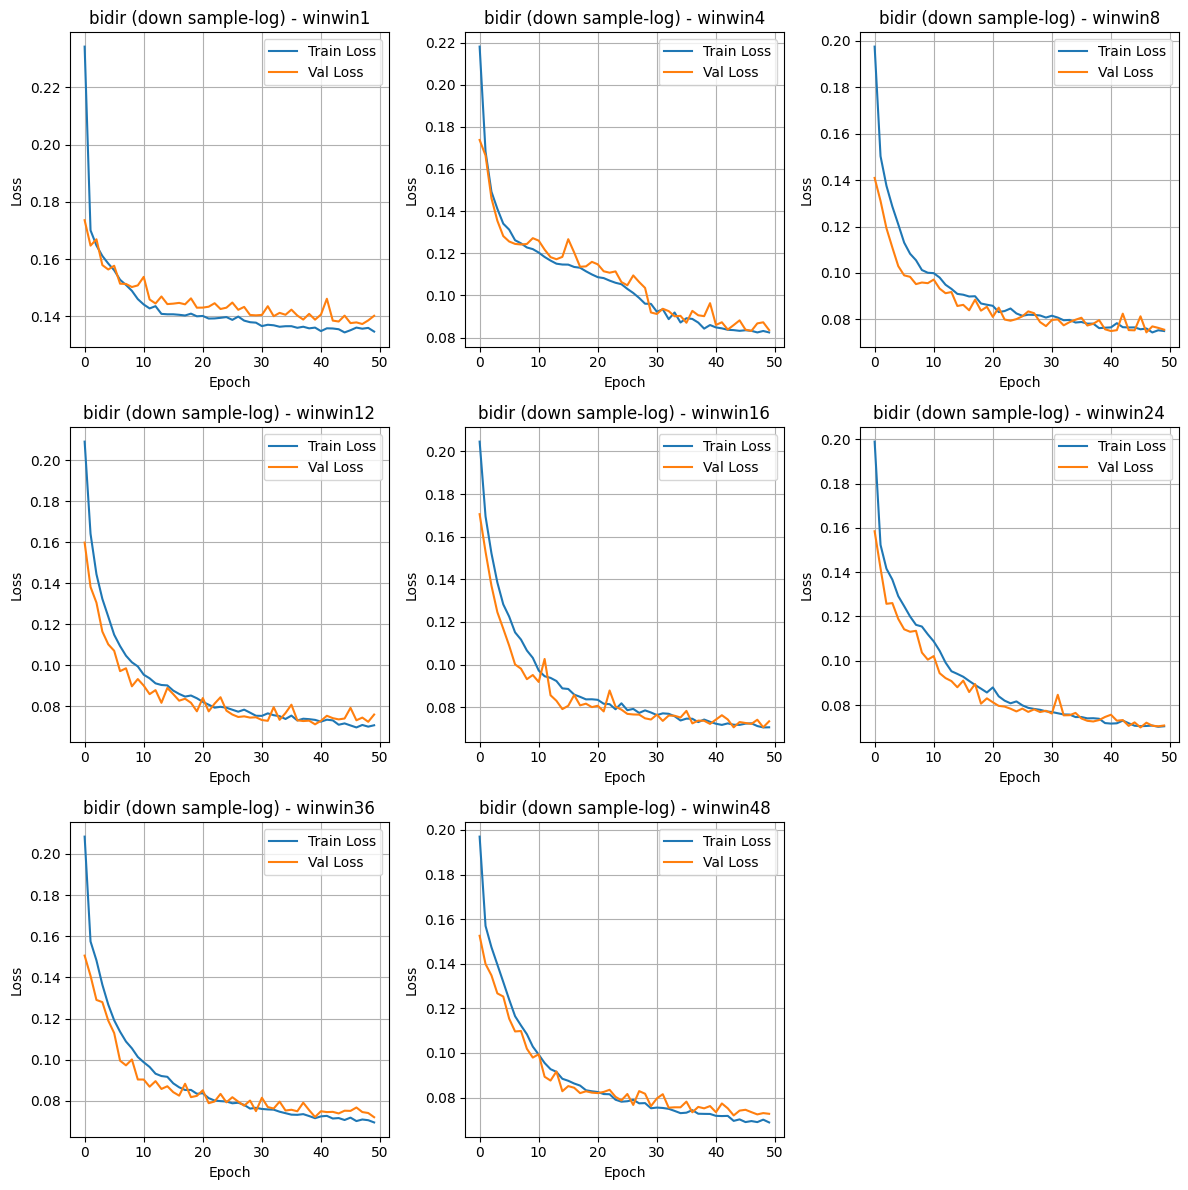

==> Window: 74
--> (7122, 74, 8) (7122,) (1564, 74, 8)
✅ Loaded model and history for window 74
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/bidir/plots/bidir_(down_sample-log)_loss_grid.png


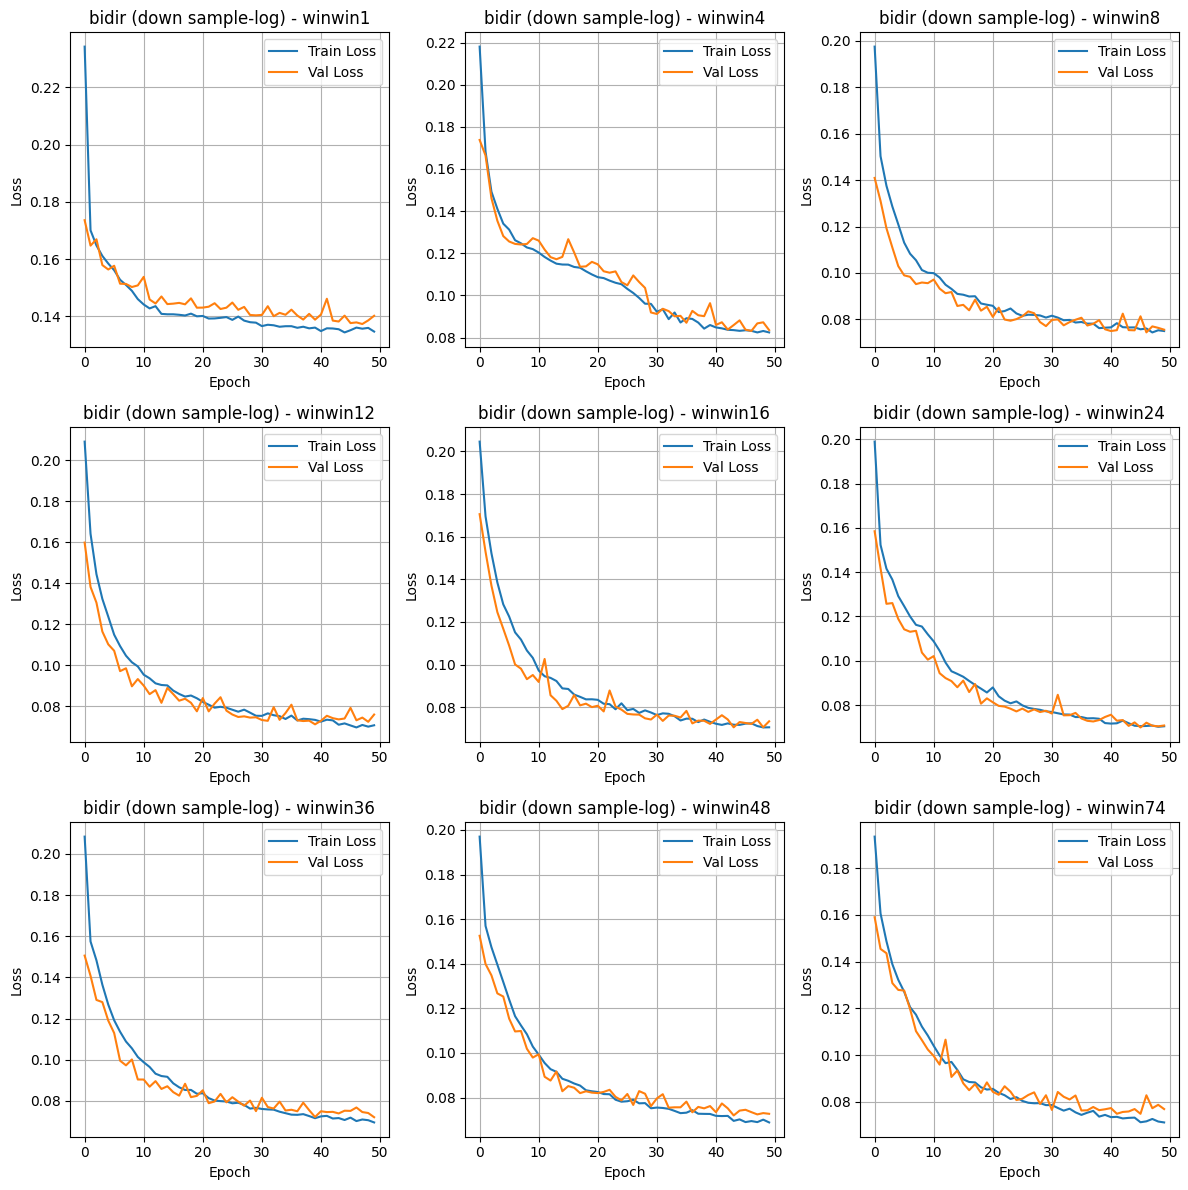

==> Window: 168
--> (7045, 168, 8) (7045,) (1547, 168, 8)
✅ Loaded model and history for window 168
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/bidir/plots/bidir_(down_sample-log)_loss_grid.png


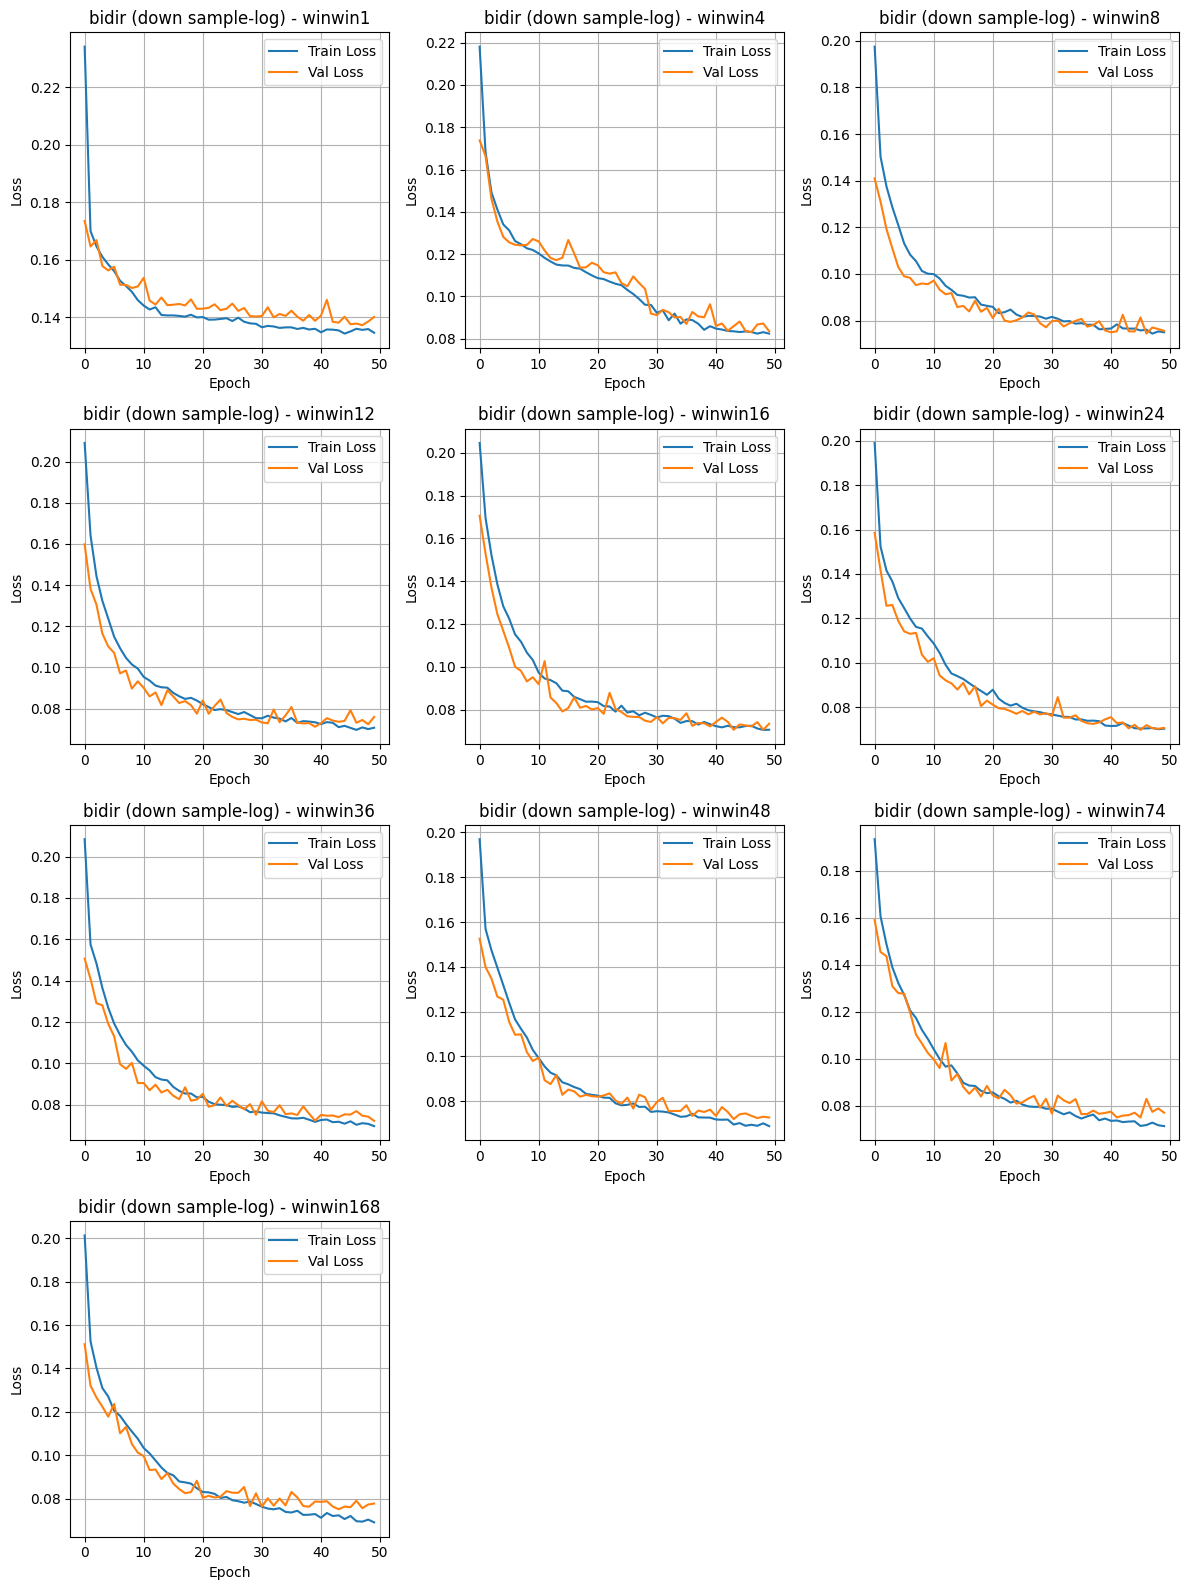

==> Window: 336
--> (6907, 336, 8) (6907,) (1517, 336, 8)
✅ Loaded model and history for window 336
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/bidir/plots/bidir_(down_sample-log)_loss_grid.png


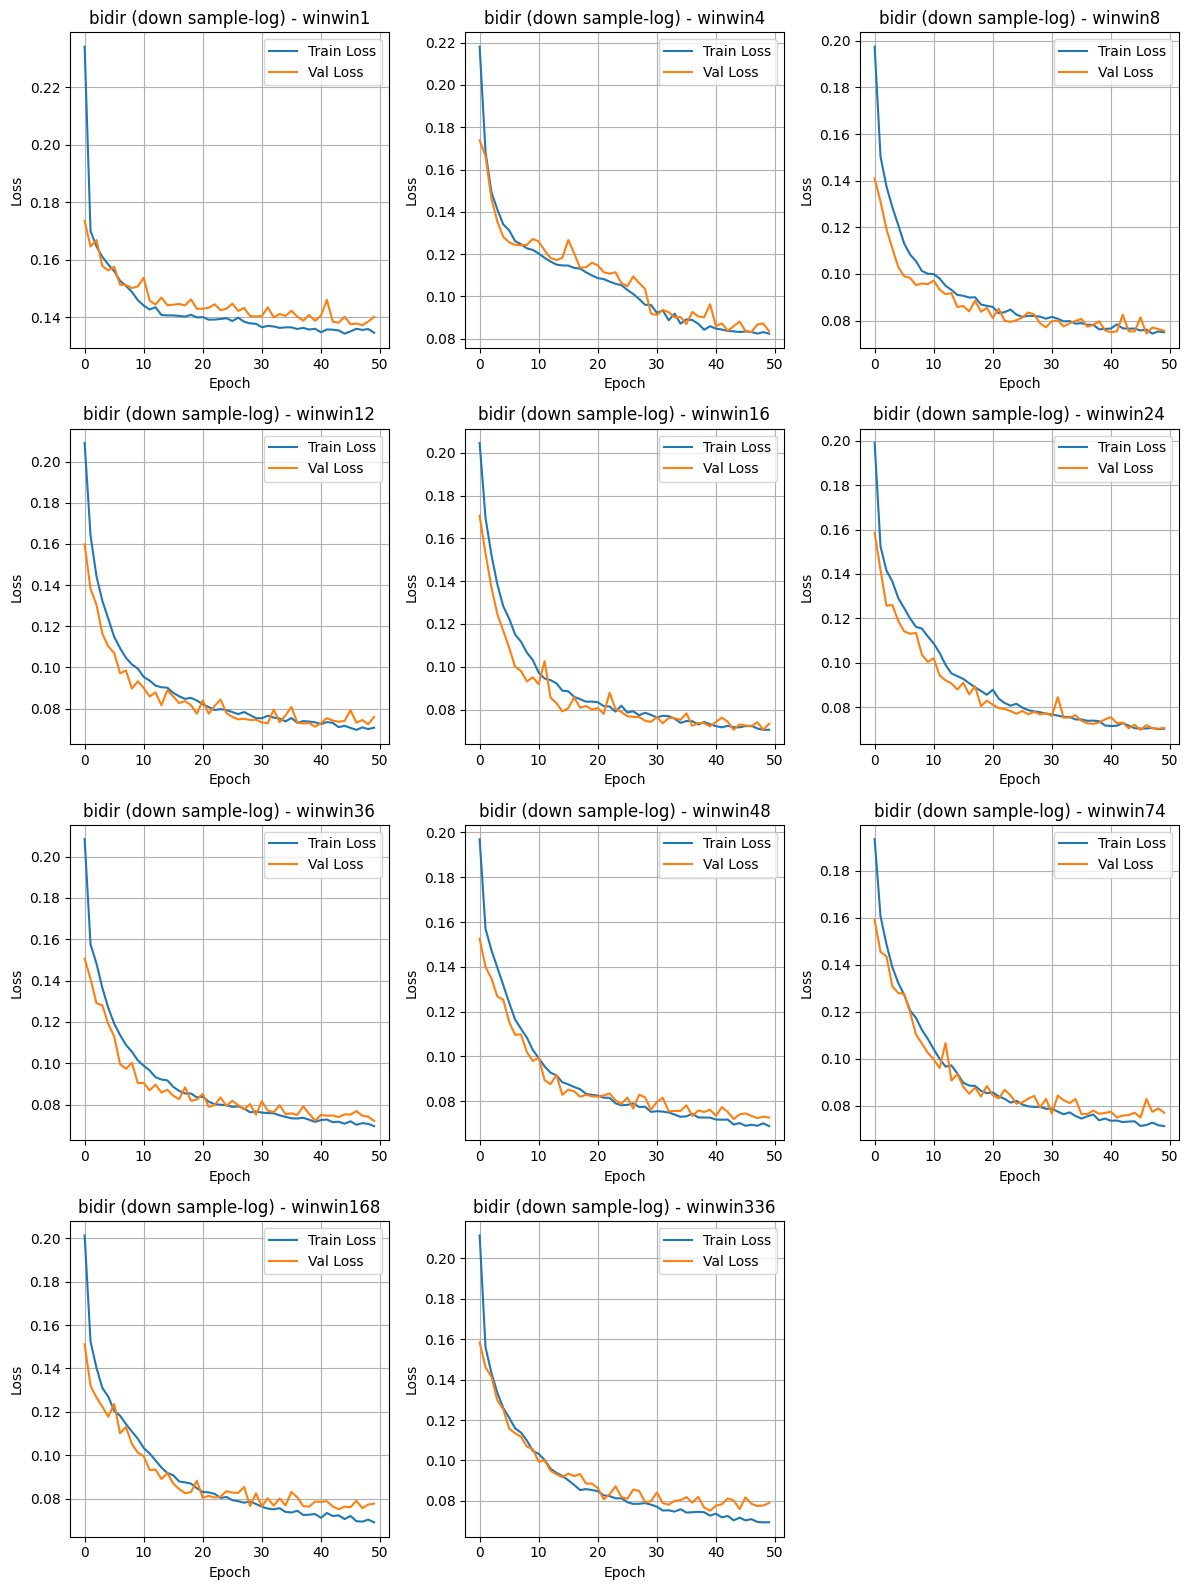

==> Window: 672
--> (6632, 672, 8) (6632,) (1456, 672, 8)
✅ Loaded model and history for window 672
✅ Saved figure to: /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/bidir/plots/bidir_(down_sample-log)_loss_grid.png


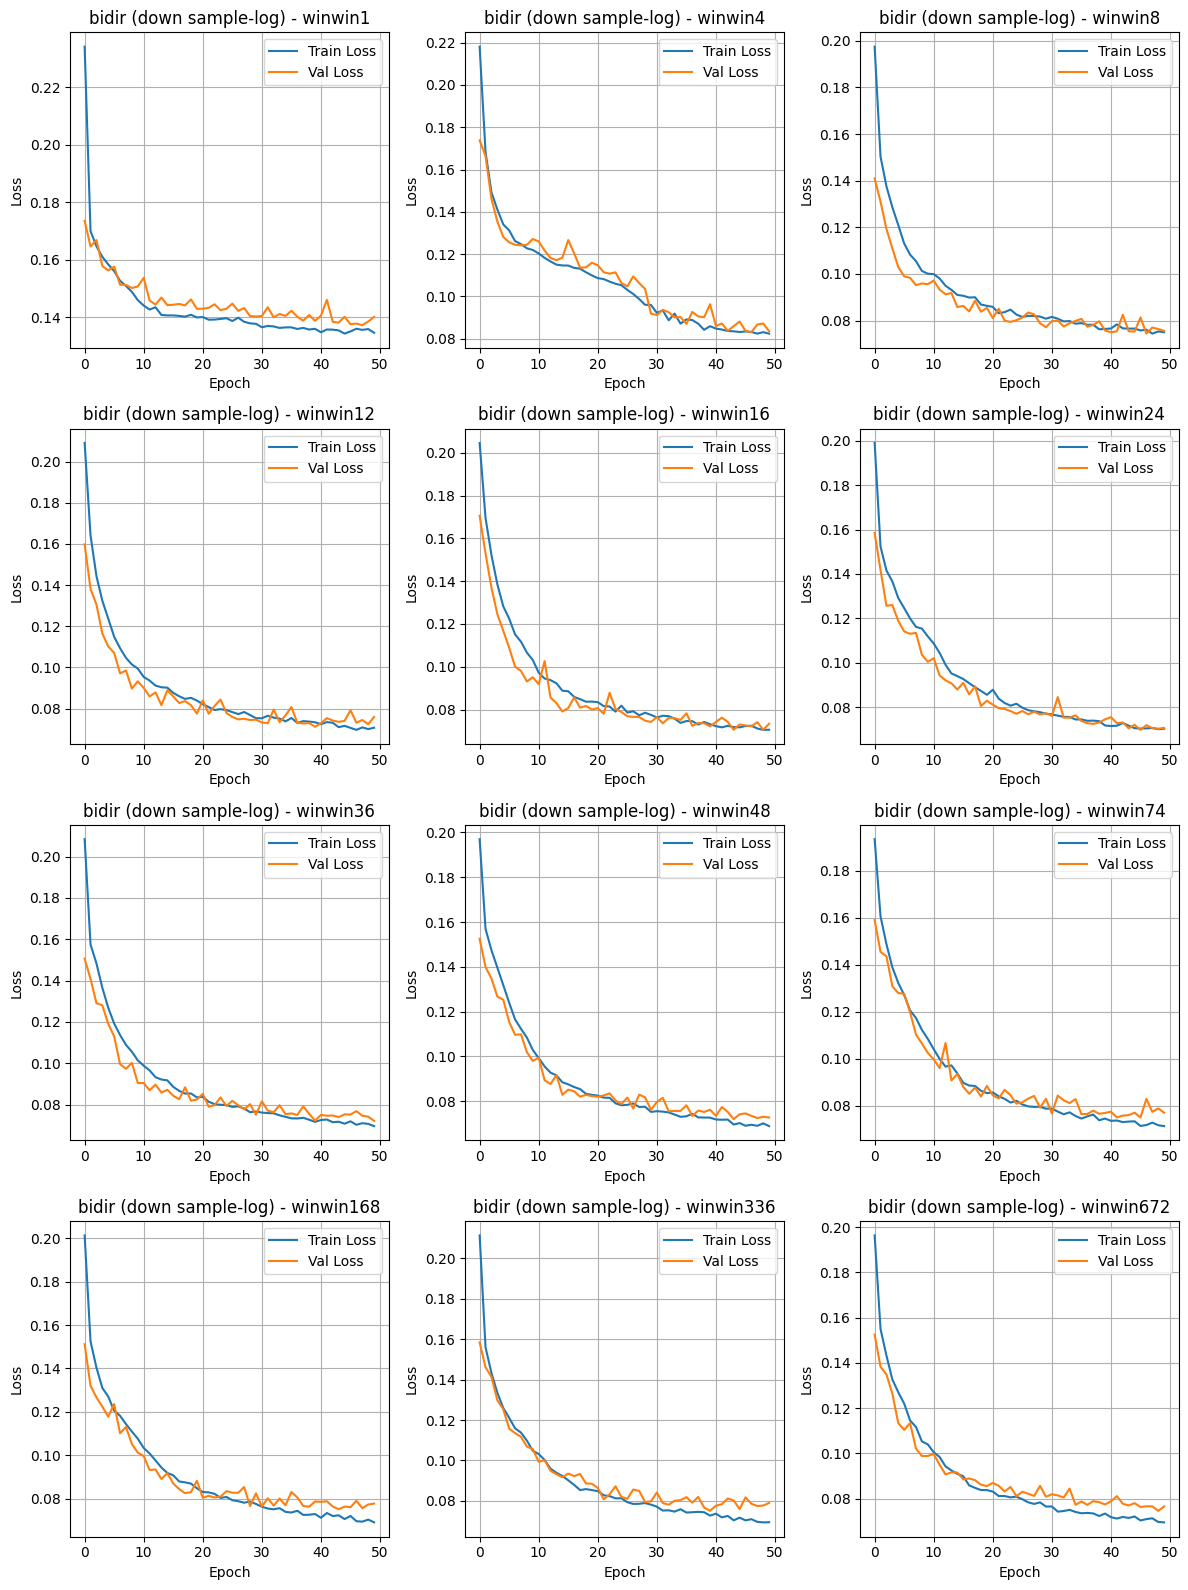

In [22]:
bidir_models = train("bidir", bidir_model_dir, bidir_history_dir, bidir_path)

In [23]:
# import matplotlib.pyplot as plt

# for key, content in single_models.items():
#     history_data = content["history"]
#     if history_data:
#         plt.figure()
#         plt.plot(history_data['loss'], label='Train Loss')
#         if 'val_loss' in history_data:
#             plt.plot(history_data['val_loss'], label='Val Loss')
#         plt.title(f"Loss Curve for {key}")
#         plt.legend()
#         plt.show()

In [24]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def compute_wia(y_true, y_pred):
    y_mean = np.mean(y_true)
    numerator = np.sum((y_true - y_pred)**2)
    denominator = np.sum((np.abs(y_pred - y_mean) + np.abs(y_true - y_mean))**2)
    return 1 - (numerator / denominator) if denominator != 0 else np.nan

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test).flatten()
    y_test = y_test.flatten()

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    wia = compute_wia(y_test, y_pred)

    return {
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "WIA": wia
    }


In [25]:
model_groups = {
    "Single": single_models,
    "Double": double_models,
    "Bidirectional": bidir_models
}

evaluation_results = {}

for model_type, models_dict in model_groups.items():
    print(f"\n=== Evaluating {model_type} Models ===")
    evaluation_results[model_type] = {}

    for key, content in models_dict.items():
        model = content["model"]
        if model is None:
            print(f"❌ {model_type} model missing for {key}")
            continue

        X_test = data[key]["X_test"]
        y_test = data[key]["y_test"]

        metrics = evaluate_model(model, X_test, y_test)
        evaluation_results[model_type][key] = metrics

        print(f"{model_type} - {key} -> "
              f"RMSE: {metrics['RMSE']:.4f}, "
              f"MAE: {metrics['MAE']:.4f}, "
              f"R²: {metrics['R2']:.4f}, "
              f"WIA: {metrics['WIA']:.4f}"
              )




=== Evaluating Single Models ===
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Single - win1 -> RMSE: 0.1366, MAE: 0.0916, R²: 0.8259, WIA: 0.9527
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Single - win4 -> RMSE: 0.0975, MAE: 0.0585, R²: 0.9113, WIA: 0.9781
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Single - win8 -> RMSE: 0.0906, MAE: 0.0520, R²: 0.9234, WIA: 0.9808
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Single - win12 -> RMSE: 0.0914, MAE: 0.0533, R²: 0.9221, WIA: 0.9804
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Single - win16 -> RMSE: 0.0991, MAE: 0.0590, R²: 0.9084, WIA: 0.9759
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Single - win24 -> RMSE: 0.0976, MAE: 0.0564, R²: 0.9112, WIA: 0.9776
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Single - win36 -> RMSE: 0.0928, MAE: 0.0540, R²: 0.9197, WIA: 0.9794
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Single - win48 -> RMSE: 0.0916, MAE: 0.0562, R²: 0.9218, WIA: 0.9792
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Single - win74 -> RMSE: 0.0996, MAE: 0.0652, R²: 0.9076, WIA: 0.97

In [26]:
data_for_df = []
for model_type, results_by_window in evaluation_results.items():
    for window, metrics in results_by_window.items():
        row = {"Model Type": model_type, "Window Size": window}
        row.update(metrics)
        data_for_df.append(row)

model_order = ["Single", "Double", "Bidirectional"]
window_order = [f"win{w}" for w in window_sizes]

df_eval = pd.DataFrame(data_for_df)

# Set the correct ordering as categorical indexes
df_eval["Model Type"] = pd.Categorical(df_eval["Model Type"], categories=model_order, ordered=True)
df_eval["Window Size"] = pd.Categorical(df_eval["Window Size"], categories=window_order, ordered=True)

# Now set index and reshape, order is preserved
df_eval = df_eval.set_index(["Window Size", "Model Type"])
df_eval = df_eval.unstack(level=1)

# Optional: clean up column MultiIndex
df_eval.columns = df_eval.columns.swaplevel(0, 1)
df_eval = df_eval.sort_index(axis=1, level=0, sort_remaining=False)

# Display final table
display(df_eval)

Model Type     Single                                  Double            \
                 RMSE       MAE        R2       WIA      RMSE       MAE   
Window Size                                                               
win1         0.136628  0.091650  0.825853  0.952695  0.131375  0.088083   
win4         0.097514  0.058492  0.911291  0.978128  0.094524  0.054027   
win8         0.090618  0.051984  0.923401  0.980783  0.097583  0.055821   
win12        0.091371  0.053255  0.922142  0.980431  0.091952  0.052864   
win16        0.099125  0.058974  0.908356  0.975949  0.094369  0.055921   
win24        0.097586  0.056429  0.911175  0.977558  0.088973  0.051606   
win36        0.092781  0.054024  0.919750  0.979447  0.094650  0.055843   
win48        0.091625  0.056175  0.921762  0.979152  0.088534  0.052616   
win74        0.099623  0.065234  0.907555  0.975173  0.095480  0.058680   
win168       0.098634  0.059689  0.909506  0.975986  0.088113  0.051967   
win336       0.101739  0.063604  0.903065  0.973594  0.101397  0.060660   
win672       0.102475  0.061468  0.900989  0.973931  0.101503  0.055983   

Model Type                      Bidirectional                                
                   R2       WIA          RMSE       MAE        R2       WIA  
Window Size                                                                  
win1         0.838987  0.956416      0.134710  0.087871  0.830709  0.954908  
win4         0.916647  0.979140      0.097736  0.056962  0.910885  0.977333  
win8         0.911174  0.977298      0.098502  0.057012  0.909492  0.978423  
win12        0.921148  0.979254      0.090316  0.052282  0.923929  0.980065  
win16        0.916941  0.978884      0.096634  0.054210  0.912905  0.978103  
win24        0.926163  0.980630      0.091663  0.056991  0.921631  0.978907  
win36        0.916485  0.977987      0.090634  0.054213  0.923422  0.979988  
win48        0.926952  0.980627      0.099223  0.061115  0.908250  0.975735  
win74        0.915085  0.977868      0.089433  0.057722  0.925500  0.979676  
win168       0.927782  0.980994      0.091657  0.057105  0.921856  0.978854  
win336       0.903716  0.974218      0.112690  0.070359  0.881076  0.968295  
win672       0.902859  0.975960      0.095752  0.059438  0.913554  0.977279

In [27]:
# Flatten MultiIndex columns into single strings like "Single_RMSE"
df_export = df_eval.copy()
df_export.columns = [f"{model}_{metric}" for model, metric in df_export.columns]


In [31]:
# Save to CSV
df_export.to_csv(f"{base_path}/results.csv")
